# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

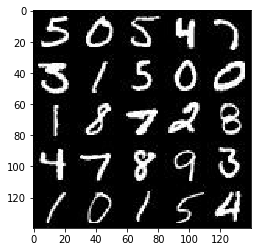

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

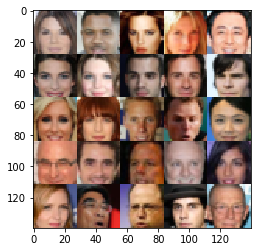

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    realInputImg = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="realInputImg")
    inputZ = tf.placeholder(tf.float32, shape=[None, z_dim], name="inputZ")
    learningRate = tf.placeholder(tf.float32, name="learningRate")

    return realInputImg, inputZ, learningRate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        # first conv layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        # second conv layer
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # third conv layer
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)

        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # shape = 7x7x512
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        #conv layer 1
        # shape = 14x14x256
        conv1 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        #conv layer 2
        # shape = 28x28x128
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)   
        
        #o/p layer
        # shape = 28x28x5

        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 3, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    gen_output = generator(input_z, out_channel_dim)
    
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(gen_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake


    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # discriminator and generator variables
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    steps = 0
    total_steps = epoch_count * batch_size
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                                          
                                          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


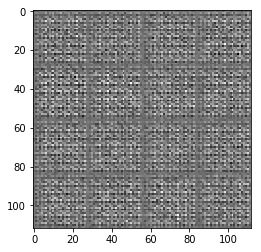

Epoch 1/2... Generator Loss: 4.1600 Discriminator Loss: 0.4022...
Epoch 1/2... Generator Loss: 4.2647 Discriminator Loss: 0.3547...
Epoch 1/2... Generator Loss: 2.3027 Discriminator Loss: 0.4600...
Epoch 1/2... Generator Loss: 2.6112 Discriminator Loss: 0.5650...
Epoch 1/2... Generator Loss: 0.5450 Discriminator Loss: 1.8541...
Epoch 1/2... Generator Loss: 3.8008 Discriminator Loss: 0.5663...
Epoch 1/2... Generator Loss: 1.2860 Discriminator Loss: 0.9294...
Epoch 1/2... Generator Loss: 1.1534 Discriminator Loss: 0.9930...
Epoch 1/2... Generator Loss: 0.8496 Discriminator Loss: 1.1757...
Epoch 1/2... Generator Loss: 1.2336 Discriminator Loss: 1.0545...


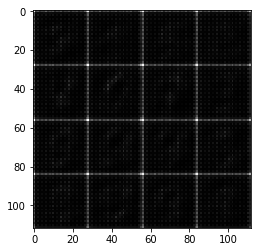

Epoch 1/2... Generator Loss: 1.0521 Discriminator Loss: 1.2840...
Epoch 1/2... Generator Loss: 1.1870 Discriminator Loss: 1.4730...
Epoch 1/2... Generator Loss: 0.8987 Discriminator Loss: 1.2654...
Epoch 1/2... Generator Loss: 0.5050 Discriminator Loss: 1.5712...
Epoch 1/2... Generator Loss: 1.0476 Discriminator Loss: 1.2067...
Epoch 1/2... Generator Loss: 0.7802 Discriminator Loss: 1.2860...
Epoch 1/2... Generator Loss: 0.8227 Discriminator Loss: 1.1837...
Epoch 1/2... Generator Loss: 0.9880 Discriminator Loss: 1.2356...
Epoch 1/2... Generator Loss: 0.7005 Discriminator Loss: 1.2378...
Epoch 1/2... Generator Loss: 0.7480 Discriminator Loss: 1.2482...


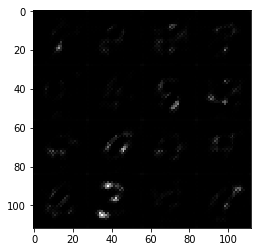

Epoch 1/2... Generator Loss: 0.6755 Discriminator Loss: 1.2732...
Epoch 1/2... Generator Loss: 0.6970 Discriminator Loss: 1.2864...
Epoch 1/2... Generator Loss: 1.2536 Discriminator Loss: 1.0936...
Epoch 1/2... Generator Loss: 0.6500 Discriminator Loss: 1.3018...
Epoch 1/2... Generator Loss: 1.2541 Discriminator Loss: 1.2018...
Epoch 1/2... Generator Loss: 1.2613 Discriminator Loss: 0.8807...
Epoch 1/2... Generator Loss: 0.9863 Discriminator Loss: 1.0671...
Epoch 1/2... Generator Loss: 0.8538 Discriminator Loss: 1.0427...
Epoch 1/2... Generator Loss: 1.0026 Discriminator Loss: 0.9804...
Epoch 1/2... Generator Loss: 1.0300 Discriminator Loss: 0.9204...


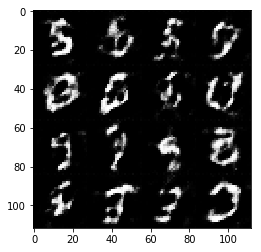

Epoch 1/2... Generator Loss: 0.7878 Discriminator Loss: 1.0892...
Epoch 1/2... Generator Loss: 0.9609 Discriminator Loss: 1.0126...
Epoch 1/2... Generator Loss: 0.8600 Discriminator Loss: 1.0673...
Epoch 1/2... Generator Loss: 0.6978 Discriminator Loss: 1.1494...
Epoch 1/2... Generator Loss: 0.7583 Discriminator Loss: 1.1065...
Epoch 1/2... Generator Loss: 1.0714 Discriminator Loss: 1.0362...
Epoch 1/2... Generator Loss: 0.6695 Discriminator Loss: 1.2294...
Epoch 1/2... Generator Loss: 1.2356 Discriminator Loss: 0.9813...
Epoch 1/2... Generator Loss: 0.8113 Discriminator Loss: 1.1100...
Epoch 1/2... Generator Loss: 1.0379 Discriminator Loss: 1.0858...


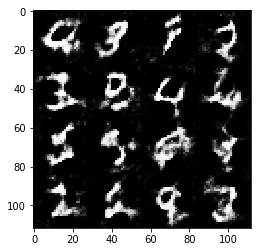

Epoch 1/2... Generator Loss: 1.0796 Discriminator Loss: 1.0913...
Epoch 1/2... Generator Loss: 1.3336 Discriminator Loss: 1.2034...
Epoch 1/2... Generator Loss: 0.7894 Discriminator Loss: 1.2540...
Epoch 1/2... Generator Loss: 0.9096 Discriminator Loss: 1.1347...
Epoch 1/2... Generator Loss: 0.6402 Discriminator Loss: 1.3521...
Epoch 1/2... Generator Loss: 1.6287 Discriminator Loss: 1.1368...
Epoch 1/2... Generator Loss: 0.8408 Discriminator Loss: 1.1856...
Epoch 1/2... Generator Loss: 1.3760 Discriminator Loss: 1.0224...
Epoch 1/2... Generator Loss: 1.0526 Discriminator Loss: 1.0538...
Epoch 1/2... Generator Loss: 0.4421 Discriminator Loss: 1.5041...


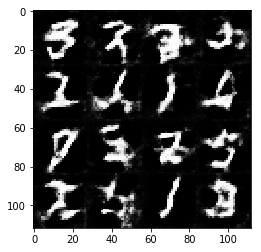

Epoch 1/2... Generator Loss: 0.7772 Discriminator Loss: 1.0893...
Epoch 1/2... Generator Loss: 0.6747 Discriminator Loss: 1.2346...
Epoch 1/2... Generator Loss: 0.7833 Discriminator Loss: 1.1714...
Epoch 1/2... Generator Loss: 0.8985 Discriminator Loss: 1.0951...
Epoch 1/2... Generator Loss: 0.8776 Discriminator Loss: 1.1829...
Epoch 1/2... Generator Loss: 0.7459 Discriminator Loss: 1.2213...
Epoch 1/2... Generator Loss: 0.7371 Discriminator Loss: 1.2527...
Epoch 1/2... Generator Loss: 1.5970 Discriminator Loss: 1.0824...
Epoch 1/2... Generator Loss: 0.8542 Discriminator Loss: 1.1584...
Epoch 1/2... Generator Loss: 0.9186 Discriminator Loss: 0.9829...


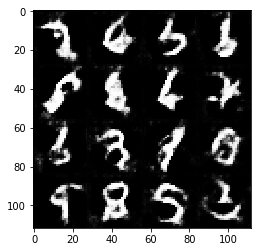

Epoch 1/2... Generator Loss: 0.7868 Discriminator Loss: 1.2398...
Epoch 1/2... Generator Loss: 1.4224 Discriminator Loss: 1.0299...
Epoch 1/2... Generator Loss: 1.1789 Discriminator Loss: 0.9732...
Epoch 1/2... Generator Loss: 1.8994 Discriminator Loss: 1.1429...
Epoch 1/2... Generator Loss: 1.1735 Discriminator Loss: 1.0510...
Epoch 1/2... Generator Loss: 1.0395 Discriminator Loss: 1.0394...
Epoch 1/2... Generator Loss: 0.6000 Discriminator Loss: 1.3940...
Epoch 1/2... Generator Loss: 0.6992 Discriminator Loss: 1.2278...
Epoch 1/2... Generator Loss: 1.4679 Discriminator Loss: 1.1770...
Epoch 1/2... Generator Loss: 1.1357 Discriminator Loss: 0.9387...


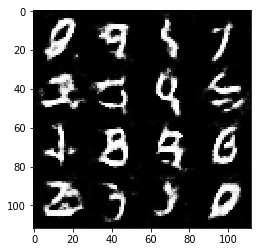

Epoch 1/2... Generator Loss: 1.0878 Discriminator Loss: 1.0757...
Epoch 1/2... Generator Loss: 0.8941 Discriminator Loss: 1.1103...
Epoch 1/2... Generator Loss: 1.0088 Discriminator Loss: 1.0699...
Epoch 1/2... Generator Loss: 0.5852 Discriminator Loss: 1.2855...
Epoch 1/2... Generator Loss: 0.6806 Discriminator Loss: 1.1841...
Epoch 1/2... Generator Loss: 0.8951 Discriminator Loss: 1.0295...
Epoch 1/2... Generator Loss: 0.9229 Discriminator Loss: 1.0606...
Epoch 1/2... Generator Loss: 0.9516 Discriminator Loss: 1.1004...
Epoch 1/2... Generator Loss: 1.0894 Discriminator Loss: 1.0745...
Epoch 1/2... Generator Loss: 1.1507 Discriminator Loss: 1.0874...


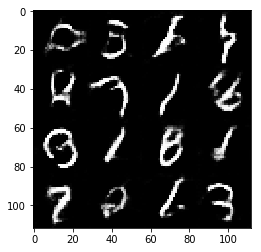

Epoch 1/2... Generator Loss: 0.7557 Discriminator Loss: 1.2006...
Epoch 1/2... Generator Loss: 1.1695 Discriminator Loss: 1.0300...
Epoch 1/2... Generator Loss: 1.0621 Discriminator Loss: 0.9865...
Epoch 1/2... Generator Loss: 0.9330 Discriminator Loss: 1.1379...
Epoch 1/2... Generator Loss: 1.3595 Discriminator Loss: 1.0333...
Epoch 1/2... Generator Loss: 1.1462 Discriminator Loss: 1.0779...
Epoch 1/2... Generator Loss: 0.5776 Discriminator Loss: 1.3083...
Epoch 1/2... Generator Loss: 0.9867 Discriminator Loss: 0.9807...
Epoch 1/2... Generator Loss: 0.5269 Discriminator Loss: 1.3768...
Epoch 1/2... Generator Loss: 0.9886 Discriminator Loss: 1.0585...


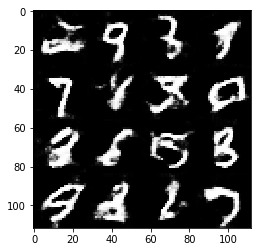

Epoch 1/2... Generator Loss: 1.0344 Discriminator Loss: 1.0605...
Epoch 1/2... Generator Loss: 0.8766 Discriminator Loss: 1.0851...
Epoch 1/2... Generator Loss: 1.2006 Discriminator Loss: 1.1372...
Epoch 1/2... Generator Loss: 1.0533 Discriminator Loss: 1.0188...
Epoch 1/2... Generator Loss: 1.2193 Discriminator Loss: 1.0083...
Epoch 1/2... Generator Loss: 1.6419 Discriminator Loss: 0.8399...
Epoch 1/2... Generator Loss: 1.0292 Discriminator Loss: 0.9758...
Epoch 1/2... Generator Loss: 0.6271 Discriminator Loss: 1.2173...
Epoch 1/2... Generator Loss: 0.7442 Discriminator Loss: 1.1819...
Epoch 1/2... Generator Loss: 0.6757 Discriminator Loss: 1.2665...


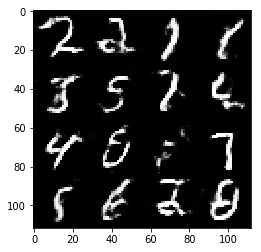

Epoch 1/2... Generator Loss: 0.6829 Discriminator Loss: 1.3027...
Epoch 1/2... Generator Loss: 0.9465 Discriminator Loss: 1.0713...
Epoch 1/2... Generator Loss: 1.1917 Discriminator Loss: 0.9034...
Epoch 1/2... Generator Loss: 1.0969 Discriminator Loss: 0.9921...
Epoch 1/2... Generator Loss: 0.7701 Discriminator Loss: 1.1203...
Epoch 1/2... Generator Loss: 1.0305 Discriminator Loss: 1.0415...
Epoch 1/2... Generator Loss: 1.9600 Discriminator Loss: 0.9169...
Epoch 1/2... Generator Loss: 0.4799 Discriminator Loss: 1.4289...
Epoch 1/2... Generator Loss: 1.1087 Discriminator Loss: 0.9567...
Epoch 1/2... Generator Loss: 1.2959 Discriminator Loss: 0.8139...


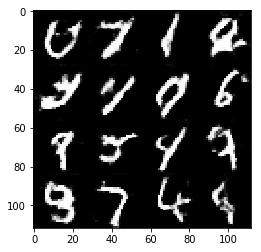

Epoch 1/2... Generator Loss: 1.7045 Discriminator Loss: 0.7253...
Epoch 1/2... Generator Loss: 0.5937 Discriminator Loss: 1.3675...
Epoch 1/2... Generator Loss: 0.6124 Discriminator Loss: 1.2333...
Epoch 1/2... Generator Loss: 0.7690 Discriminator Loss: 1.1699...
Epoch 1/2... Generator Loss: 0.8055 Discriminator Loss: 1.1202...
Epoch 1/2... Generator Loss: 1.5034 Discriminator Loss: 0.8818...
Epoch 1/2... Generator Loss: 1.3916 Discriminator Loss: 1.0644...
Epoch 1/2... Generator Loss: 0.6189 Discriminator Loss: 1.2292...
Epoch 1/2... Generator Loss: 0.8185 Discriminator Loss: 1.1097...
Epoch 1/2... Generator Loss: 1.0620 Discriminator Loss: 1.1935...


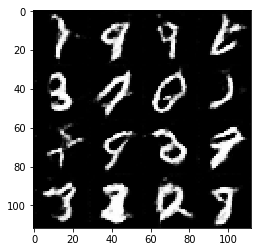

Epoch 1/2... Generator Loss: 1.2897 Discriminator Loss: 0.8952...
Epoch 1/2... Generator Loss: 0.8555 Discriminator Loss: 1.0407...
Epoch 1/2... Generator Loss: 0.5825 Discriminator Loss: 1.3257...
Epoch 1/2... Generator Loss: 0.6381 Discriminator Loss: 1.2550...
Epoch 1/2... Generator Loss: 1.2239 Discriminator Loss: 0.9758...
Epoch 1/2... Generator Loss: 0.9525 Discriminator Loss: 1.0259...
Epoch 1/2... Generator Loss: 1.8983 Discriminator Loss: 1.0392...
Epoch 1/2... Generator Loss: 1.3784 Discriminator Loss: 1.1160...
Epoch 1/2... Generator Loss: 1.3237 Discriminator Loss: 0.8854...
Epoch 1/2... Generator Loss: 1.4465 Discriminator Loss: 0.8860...


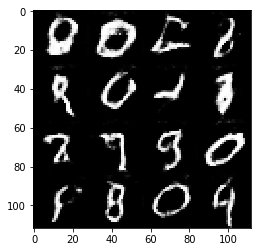

Epoch 1/2... Generator Loss: 1.4718 Discriminator Loss: 1.0280...
Epoch 1/2... Generator Loss: 1.4017 Discriminator Loss: 0.9537...
Epoch 1/2... Generator Loss: 0.7049 Discriminator Loss: 1.1717...
Epoch 1/2... Generator Loss: 0.6268 Discriminator Loss: 1.2484...
Epoch 1/2... Generator Loss: 0.6282 Discriminator Loss: 1.2788...
Epoch 1/2... Generator Loss: 0.8750 Discriminator Loss: 1.0426...
Epoch 1/2... Generator Loss: 1.4235 Discriminator Loss: 0.8883...
Epoch 1/2... Generator Loss: 0.4252 Discriminator Loss: 1.5997...
Epoch 1/2... Generator Loss: 0.5655 Discriminator Loss: 1.3625...
Epoch 1/2... Generator Loss: 0.6360 Discriminator Loss: 1.1900...


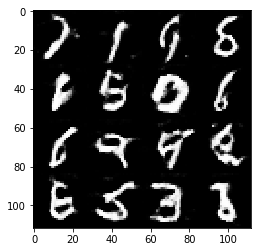

Epoch 1/2... Generator Loss: 0.8519 Discriminator Loss: 1.0765...
Epoch 1/2... Generator Loss: 1.4727 Discriminator Loss: 0.8217...
Epoch 1/2... Generator Loss: 1.4986 Discriminator Loss: 1.1145...
Epoch 1/2... Generator Loss: 1.2344 Discriminator Loss: 0.9206...
Epoch 1/2... Generator Loss: 0.9720 Discriminator Loss: 1.0632...
Epoch 1/2... Generator Loss: 1.1935 Discriminator Loss: 0.8390...
Epoch 1/2... Generator Loss: 1.1982 Discriminator Loss: 0.8142...
Epoch 1/2... Generator Loss: 1.5960 Discriminator Loss: 0.8628...
Epoch 1/2... Generator Loss: 1.2459 Discriminator Loss: 1.0465...
Epoch 1/2... Generator Loss: 0.8050 Discriminator Loss: 1.1404...


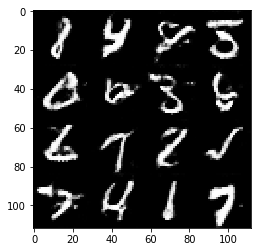

Epoch 1/2... Generator Loss: 1.2814 Discriminator Loss: 0.9969...
Epoch 1/2... Generator Loss: 0.8547 Discriminator Loss: 1.0712...
Epoch 1/2... Generator Loss: 0.7186 Discriminator Loss: 1.2216...
Epoch 1/2... Generator Loss: 0.9495 Discriminator Loss: 1.0137...
Epoch 1/2... Generator Loss: 0.7938 Discriminator Loss: 1.0561...
Epoch 1/2... Generator Loss: 0.6962 Discriminator Loss: 1.5135...
Epoch 1/2... Generator Loss: 1.2466 Discriminator Loss: 0.8613...
Epoch 1/2... Generator Loss: 0.6552 Discriminator Loss: 1.2753...
Epoch 1/2... Generator Loss: 0.5676 Discriminator Loss: 1.4443...
Epoch 1/2... Generator Loss: 1.2930 Discriminator Loss: 0.9630...


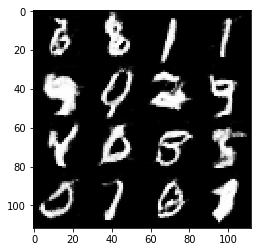

Epoch 1/2... Generator Loss: 1.1061 Discriminator Loss: 0.9213...
Epoch 1/2... Generator Loss: 0.7006 Discriminator Loss: 1.2192...
Epoch 1/2... Generator Loss: 0.5292 Discriminator Loss: 1.3715...
Epoch 1/2... Generator Loss: 0.6750 Discriminator Loss: 1.1821...
Epoch 1/2... Generator Loss: 0.4649 Discriminator Loss: 1.5466...
Epoch 1/2... Generator Loss: 1.2950 Discriminator Loss: 0.9127...
Epoch 1/2... Generator Loss: 0.9205 Discriminator Loss: 0.9543...
Epoch 1/2... Generator Loss: 1.1332 Discriminator Loss: 1.1910...
Epoch 1/2... Generator Loss: 1.5925 Discriminator Loss: 0.7907...
Epoch 1/2... Generator Loss: 1.0366 Discriminator Loss: 1.0164...


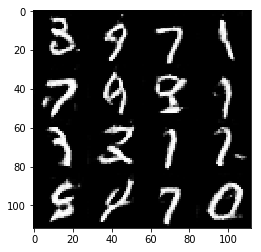

Epoch 1/2... Generator Loss: 0.7649 Discriminator Loss: 1.1127...
Epoch 1/2... Generator Loss: 0.4010 Discriminator Loss: 1.7239...
Epoch 1/2... Generator Loss: 0.8193 Discriminator Loss: 1.1082...
Epoch 1/2... Generator Loss: 1.2959 Discriminator Loss: 0.8776...
Epoch 1/2... Generator Loss: 1.3944 Discriminator Loss: 1.0776...
Epoch 1/2... Generator Loss: 0.9924 Discriminator Loss: 1.1172...
Epoch 1/2... Generator Loss: 1.2186 Discriminator Loss: 0.8078...
Epoch 1/2... Generator Loss: 1.4157 Discriminator Loss: 0.9491...
Epoch 1/2... Generator Loss: 1.2937 Discriminator Loss: 0.9280...
Epoch 1/2... Generator Loss: 1.7129 Discriminator Loss: 0.8185...


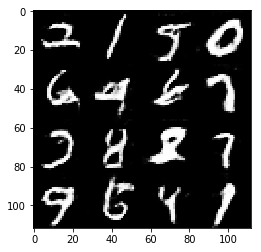

Epoch 1/2... Generator Loss: 1.0431 Discriminator Loss: 1.2005...
Epoch 1/2... Generator Loss: 0.9641 Discriminator Loss: 1.0456...
Epoch 1/2... Generator Loss: 0.8996 Discriminator Loss: 1.0163...
Epoch 1/2... Generator Loss: 0.8467 Discriminator Loss: 1.1039...
Epoch 1/2... Generator Loss: 1.1796 Discriminator Loss: 0.8883...
Epoch 1/2... Generator Loss: 0.8502 Discriminator Loss: 1.1166...
Epoch 1/2... Generator Loss: 0.7669 Discriminator Loss: 1.1174...
Epoch 2/2... Generator Loss: 0.7523 Discriminator Loss: 1.1398...
Epoch 2/2... Generator Loss: 1.5102 Discriminator Loss: 0.7970...
Epoch 2/2... Generator Loss: 0.5102 Discriminator Loss: 1.3848...


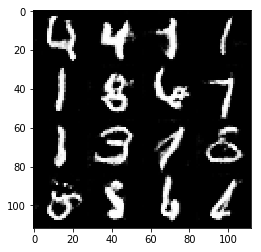

Epoch 2/2... Generator Loss: 0.6393 Discriminator Loss: 1.2093...
Epoch 2/2... Generator Loss: 1.0684 Discriminator Loss: 1.0226...
Epoch 2/2... Generator Loss: 1.0299 Discriminator Loss: 0.9401...
Epoch 2/2... Generator Loss: 1.5878 Discriminator Loss: 1.0367...
Epoch 2/2... Generator Loss: 0.7518 Discriminator Loss: 1.1755...
Epoch 2/2... Generator Loss: 0.8398 Discriminator Loss: 1.0744...
Epoch 2/2... Generator Loss: 1.2173 Discriminator Loss: 0.8507...
Epoch 2/2... Generator Loss: 1.5527 Discriminator Loss: 0.7395...
Epoch 2/2... Generator Loss: 1.4847 Discriminator Loss: 0.7813...
Epoch 2/2... Generator Loss: 1.3339 Discriminator Loss: 0.9275...


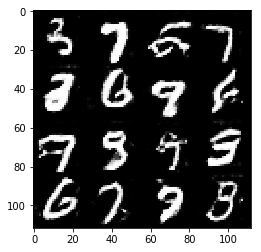

Epoch 2/2... Generator Loss: 0.9302 Discriminator Loss: 1.0099...
Epoch 2/2... Generator Loss: 1.9015 Discriminator Loss: 1.1708...
Epoch 2/2... Generator Loss: 0.5970 Discriminator Loss: 1.3242...
Epoch 2/2... Generator Loss: 0.8401 Discriminator Loss: 1.0373...
Epoch 2/2... Generator Loss: 1.0040 Discriminator Loss: 0.9243...
Epoch 2/2... Generator Loss: 1.0285 Discriminator Loss: 0.9348...
Epoch 2/2... Generator Loss: 0.9231 Discriminator Loss: 0.9890...
Epoch 2/2... Generator Loss: 1.5834 Discriminator Loss: 0.7296...
Epoch 2/2... Generator Loss: 1.1892 Discriminator Loss: 0.9235...
Epoch 2/2... Generator Loss: 1.0775 Discriminator Loss: 0.9326...


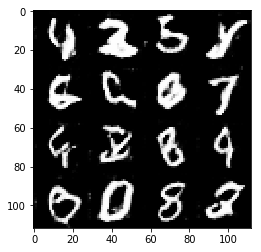

Epoch 2/2... Generator Loss: 0.9583 Discriminator Loss: 1.0417...
Epoch 2/2... Generator Loss: 1.1409 Discriminator Loss: 0.9540...
Epoch 2/2... Generator Loss: 0.8544 Discriminator Loss: 1.0786...
Epoch 2/2... Generator Loss: 0.9495 Discriminator Loss: 1.0037...
Epoch 2/2... Generator Loss: 0.9430 Discriminator Loss: 0.9639...
Epoch 2/2... Generator Loss: 0.7294 Discriminator Loss: 1.2210...
Epoch 2/2... Generator Loss: 1.4229 Discriminator Loss: 0.8001...
Epoch 2/2... Generator Loss: 1.1363 Discriminator Loss: 0.8379...
Epoch 2/2... Generator Loss: 1.3245 Discriminator Loss: 0.7955...
Epoch 2/2... Generator Loss: 0.9994 Discriminator Loss: 0.9190...


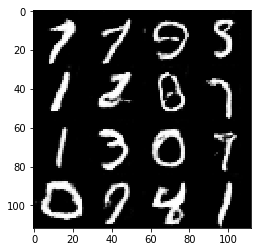

Epoch 2/2... Generator Loss: 0.5318 Discriminator Loss: 1.5138...
Epoch 2/2... Generator Loss: 1.1304 Discriminator Loss: 0.9549...
Epoch 2/2... Generator Loss: 1.2609 Discriminator Loss: 0.9473...
Epoch 2/2... Generator Loss: 0.7786 Discriminator Loss: 1.1218...
Epoch 2/2... Generator Loss: 1.4344 Discriminator Loss: 0.8285...
Epoch 2/2... Generator Loss: 0.7539 Discriminator Loss: 1.1190...
Epoch 2/2... Generator Loss: 0.7212 Discriminator Loss: 1.1126...
Epoch 2/2... Generator Loss: 0.7959 Discriminator Loss: 1.1071...
Epoch 2/2... Generator Loss: 0.8433 Discriminator Loss: 1.0551...
Epoch 2/2... Generator Loss: 0.6914 Discriminator Loss: 1.1794...


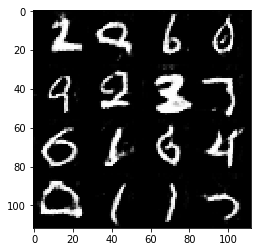

Epoch 2/2... Generator Loss: 0.9263 Discriminator Loss: 1.0046...
Epoch 2/2... Generator Loss: 0.5370 Discriminator Loss: 1.3082...
Epoch 2/2... Generator Loss: 0.9930 Discriminator Loss: 1.0682...
Epoch 2/2... Generator Loss: 0.6998 Discriminator Loss: 1.1756...
Epoch 2/2... Generator Loss: 1.0018 Discriminator Loss: 0.9878...
Epoch 2/2... Generator Loss: 2.0345 Discriminator Loss: 0.6736...
Epoch 2/2... Generator Loss: 0.6329 Discriminator Loss: 1.3620...
Epoch 2/2... Generator Loss: 1.0720 Discriminator Loss: 0.9284...
Epoch 2/2... Generator Loss: 1.3139 Discriminator Loss: 0.7699...
Epoch 2/2... Generator Loss: 0.9220 Discriminator Loss: 0.9660...


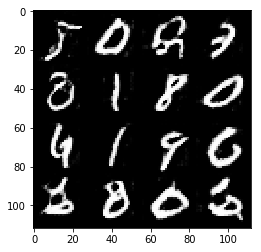

Epoch 2/2... Generator Loss: 0.6304 Discriminator Loss: 1.2566...
Epoch 2/2... Generator Loss: 1.0236 Discriminator Loss: 1.0182...
Epoch 2/2... Generator Loss: 1.2168 Discriminator Loss: 0.9079...
Epoch 2/2... Generator Loss: 1.0906 Discriminator Loss: 0.8622...
Epoch 2/2... Generator Loss: 0.6904 Discriminator Loss: 1.2298...
Epoch 2/2... Generator Loss: 0.8231 Discriminator Loss: 1.0833...
Epoch 2/2... Generator Loss: 1.0835 Discriminator Loss: 0.9965...
Epoch 2/2... Generator Loss: 1.7396 Discriminator Loss: 0.6644...
Epoch 2/2... Generator Loss: 1.4684 Discriminator Loss: 0.7892...
Epoch 2/2... Generator Loss: 0.7439 Discriminator Loss: 1.2095...


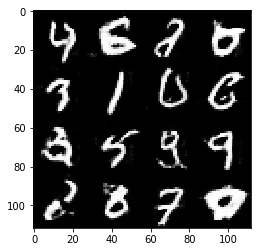

Epoch 2/2... Generator Loss: 0.6665 Discriminator Loss: 1.2068...
Epoch 2/2... Generator Loss: 1.6369 Discriminator Loss: 0.7649...
Epoch 2/2... Generator Loss: 0.7982 Discriminator Loss: 1.0979...
Epoch 2/2... Generator Loss: 0.6045 Discriminator Loss: 1.2241...
Epoch 2/2... Generator Loss: 0.3758 Discriminator Loss: 1.6272...
Epoch 2/2... Generator Loss: 0.7194 Discriminator Loss: 1.1817...
Epoch 2/2... Generator Loss: 1.0367 Discriminator Loss: 0.9322...
Epoch 2/2... Generator Loss: 1.3721 Discriminator Loss: 1.3656...
Epoch 2/2... Generator Loss: 1.0973 Discriminator Loss: 0.8596...
Epoch 2/2... Generator Loss: 1.0892 Discriminator Loss: 0.8425...


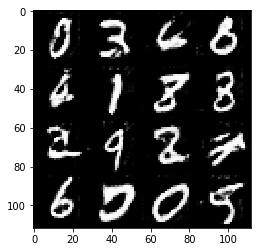

Epoch 2/2... Generator Loss: 1.7899 Discriminator Loss: 0.8649...
Epoch 2/2... Generator Loss: 0.8937 Discriminator Loss: 0.9658...
Epoch 2/2... Generator Loss: 0.8811 Discriminator Loss: 1.0882...
Epoch 2/2... Generator Loss: 1.2458 Discriminator Loss: 0.8502...
Epoch 2/2... Generator Loss: 0.5618 Discriminator Loss: 1.3177...
Epoch 2/2... Generator Loss: 1.1658 Discriminator Loss: 0.8743...
Epoch 2/2... Generator Loss: 1.0034 Discriminator Loss: 0.9487...
Epoch 2/2... Generator Loss: 1.1260 Discriminator Loss: 0.8824...
Epoch 2/2... Generator Loss: 0.2064 Discriminator Loss: 2.3565...
Epoch 2/2... Generator Loss: 1.4027 Discriminator Loss: 0.7512...


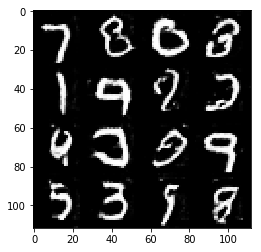

Epoch 2/2... Generator Loss: 1.2973 Discriminator Loss: 0.7564...
Epoch 2/2... Generator Loss: 1.4427 Discriminator Loss: 0.7241...
Epoch 2/2... Generator Loss: 1.1785 Discriminator Loss: 0.9678...
Epoch 2/2... Generator Loss: 0.8854 Discriminator Loss: 1.0108...
Epoch 2/2... Generator Loss: 0.9850 Discriminator Loss: 0.8940...
Epoch 2/2... Generator Loss: 1.3582 Discriminator Loss: 0.7789...
Epoch 2/2... Generator Loss: 1.4992 Discriminator Loss: 0.7024...
Epoch 2/2... Generator Loss: 0.9912 Discriminator Loss: 0.9545...
Epoch 2/2... Generator Loss: 0.7790 Discriminator Loss: 1.1613...
Epoch 2/2... Generator Loss: 0.8426 Discriminator Loss: 1.0580...


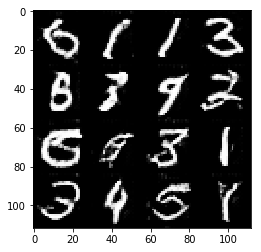

Epoch 2/2... Generator Loss: 2.1405 Discriminator Loss: 1.3400...
Epoch 2/2... Generator Loss: 1.3536 Discriminator Loss: 0.7639...
Epoch 2/2... Generator Loss: 1.6506 Discriminator Loss: 1.1070...
Epoch 2/2... Generator Loss: 0.7591 Discriminator Loss: 1.1608...
Epoch 2/2... Generator Loss: 1.3908 Discriminator Loss: 0.7823...
Epoch 2/2... Generator Loss: 1.0666 Discriminator Loss: 0.9557...
Epoch 2/2... Generator Loss: 1.3120 Discriminator Loss: 0.8064...
Epoch 2/2... Generator Loss: 1.2061 Discriminator Loss: 0.8163...
Epoch 2/2... Generator Loss: 1.2270 Discriminator Loss: 0.8481...
Epoch 2/2... Generator Loss: 0.9781 Discriminator Loss: 0.9793...


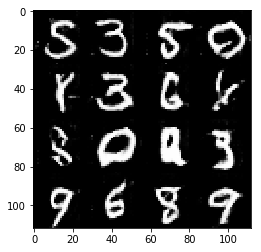

Epoch 2/2... Generator Loss: 0.8031 Discriminator Loss: 1.0907...
Epoch 2/2... Generator Loss: 1.0139 Discriminator Loss: 0.9178...
Epoch 2/2... Generator Loss: 1.2997 Discriminator Loss: 0.8320...
Epoch 2/2... Generator Loss: 1.0002 Discriminator Loss: 1.0002...
Epoch 2/2... Generator Loss: 1.8018 Discriminator Loss: 0.8097...
Epoch 2/2... Generator Loss: 1.5505 Discriminator Loss: 0.8914...
Epoch 2/2... Generator Loss: 1.2176 Discriminator Loss: 0.7932...
Epoch 2/2... Generator Loss: 0.9854 Discriminator Loss: 1.0065...
Epoch 2/2... Generator Loss: 1.0579 Discriminator Loss: 0.9198...
Epoch 2/2... Generator Loss: 0.6501 Discriminator Loss: 1.2729...


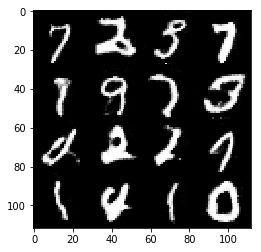

Epoch 2/2... Generator Loss: 1.4662 Discriminator Loss: 0.8372...
Epoch 2/2... Generator Loss: 0.8520 Discriminator Loss: 1.0401...
Epoch 2/2... Generator Loss: 1.5114 Discriminator Loss: 0.7392...
Epoch 2/2... Generator Loss: 0.5738 Discriminator Loss: 1.3427...
Epoch 2/2... Generator Loss: 0.3399 Discriminator Loss: 1.8091...
Epoch 2/2... Generator Loss: 1.9250 Discriminator Loss: 0.6795...
Epoch 2/2... Generator Loss: 1.2139 Discriminator Loss: 0.7782...
Epoch 2/2... Generator Loss: 1.3071 Discriminator Loss: 0.7745...
Epoch 2/2... Generator Loss: 0.9883 Discriminator Loss: 0.9534...
Epoch 2/2... Generator Loss: 1.2110 Discriminator Loss: 0.8455...


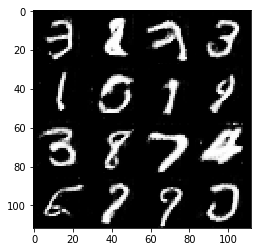

Epoch 2/2... Generator Loss: 0.5010 Discriminator Loss: 1.4558...
Epoch 2/2... Generator Loss: 1.1556 Discriminator Loss: 1.1928...
Epoch 2/2... Generator Loss: 1.5269 Discriminator Loss: 0.8652...
Epoch 2/2... Generator Loss: 1.1109 Discriminator Loss: 0.9000...
Epoch 2/2... Generator Loss: 1.2246 Discriminator Loss: 0.8326...
Epoch 2/2... Generator Loss: 1.1465 Discriminator Loss: 0.8420...
Epoch 2/2... Generator Loss: 0.8715 Discriminator Loss: 1.0516...
Epoch 2/2... Generator Loss: 1.2497 Discriminator Loss: 0.9008...
Epoch 2/2... Generator Loss: 1.3320 Discriminator Loss: 0.8516...
Epoch 2/2... Generator Loss: 0.8979 Discriminator Loss: 1.0228...


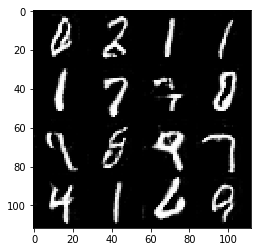

Epoch 2/2... Generator Loss: 1.2769 Discriminator Loss: 0.7819...
Epoch 2/2... Generator Loss: 0.6014 Discriminator Loss: 1.2817...
Epoch 2/2... Generator Loss: 1.2493 Discriminator Loss: 0.8119...
Epoch 2/2... Generator Loss: 0.9797 Discriminator Loss: 1.0371...
Epoch 2/2... Generator Loss: 0.9727 Discriminator Loss: 1.0522...
Epoch 2/2... Generator Loss: 1.0852 Discriminator Loss: 0.8429...
Epoch 2/2... Generator Loss: 1.3928 Discriminator Loss: 0.7653...
Epoch 2/2... Generator Loss: 1.7008 Discriminator Loss: 0.6993...
Epoch 2/2... Generator Loss: 0.7821 Discriminator Loss: 1.2279...
Epoch 2/2... Generator Loss: 1.1755 Discriminator Loss: 0.8983...


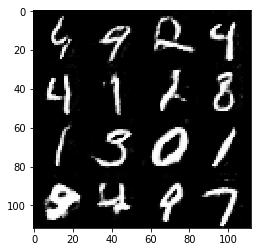

Epoch 2/2... Generator Loss: 1.0354 Discriminator Loss: 0.8923...
Epoch 2/2... Generator Loss: 1.2251 Discriminator Loss: 0.8080...
Epoch 2/2... Generator Loss: 2.0120 Discriminator Loss: 0.6533...
Epoch 2/2... Generator Loss: 1.6044 Discriminator Loss: 0.7239...
Epoch 2/2... Generator Loss: 1.1564 Discriminator Loss: 1.0559...
Epoch 2/2... Generator Loss: 1.5955 Discriminator Loss: 0.7863...
Epoch 2/2... Generator Loss: 0.7686 Discriminator Loss: 1.1116...
Epoch 2/2... Generator Loss: 1.3588 Discriminator Loss: 0.7351...
Epoch 2/2... Generator Loss: 1.2026 Discriminator Loss: 0.8684...
Epoch 2/2... Generator Loss: 1.3998 Discriminator Loss: 0.8017...


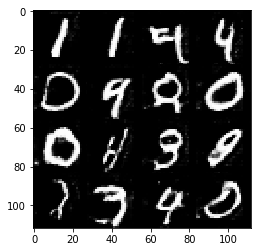

Epoch 2/2... Generator Loss: 0.8762 Discriminator Loss: 1.0003...
Epoch 2/2... Generator Loss: 1.1176 Discriminator Loss: 0.8883...
Epoch 2/2... Generator Loss: 1.2985 Discriminator Loss: 0.8028...
Epoch 2/2... Generator Loss: 0.7562 Discriminator Loss: 1.0682...
Epoch 2/2... Generator Loss: 1.3361 Discriminator Loss: 0.8029...
Epoch 2/2... Generator Loss: 0.4970 Discriminator Loss: 1.5203...
Epoch 2/2... Generator Loss: 1.6328 Discriminator Loss: 0.9203...
Epoch 2/2... Generator Loss: 1.3291 Discriminator Loss: 0.9250...
Epoch 2/2... Generator Loss: 1.6934 Discriminator Loss: 0.6509...
Epoch 2/2... Generator Loss: 1.1647 Discriminator Loss: 0.9212...


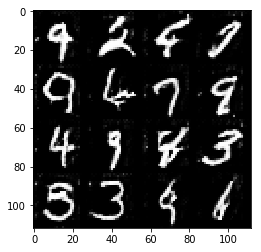

Epoch 2/2... Generator Loss: 1.3538 Discriminator Loss: 0.7881...
Epoch 2/2... Generator Loss: 1.0187 Discriminator Loss: 0.8931...
Epoch 2/2... Generator Loss: 1.9062 Discriminator Loss: 0.7997...
Epoch 2/2... Generator Loss: 1.1363 Discriminator Loss: 0.9118...
Epoch 2/2... Generator Loss: 0.6878 Discriminator Loss: 1.2688...
Epoch 2/2... Generator Loss: 0.5555 Discriminator Loss: 1.4255...
Epoch 2/2... Generator Loss: 0.6893 Discriminator Loss: 1.1464...
Epoch 2/2... Generator Loss: 1.2148 Discriminator Loss: 0.7971...
Epoch 2/2... Generator Loss: 1.1073 Discriminator Loss: 0.9051...
Epoch 2/2... Generator Loss: 1.8541 Discriminator Loss: 0.5992...


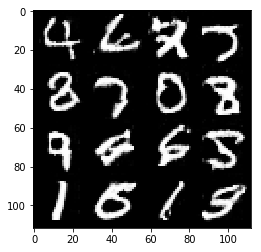

Epoch 2/2... Generator Loss: 1.0529 Discriminator Loss: 0.9388...
Epoch 2/2... Generator Loss: 0.6921 Discriminator Loss: 1.2165...
Epoch 2/2... Generator Loss: 1.2195 Discriminator Loss: 0.8110...
Epoch 2/2... Generator Loss: 1.8492 Discriminator Loss: 0.7010...
Epoch 2/2... Generator Loss: 0.7254 Discriminator Loss: 1.1706...
Epoch 2/2... Generator Loss: 1.4093 Discriminator Loss: 0.7523...
Epoch 2/2... Generator Loss: 0.7950 Discriminator Loss: 1.1285...
Epoch 2/2... Generator Loss: 0.7629 Discriminator Loss: 1.1858...
Epoch 2/2... Generator Loss: 0.5264 Discriminator Loss: 1.3826...
Epoch 2/2... Generator Loss: 0.9975 Discriminator Loss: 0.8715...


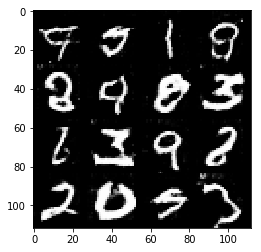

Epoch 2/2... Generator Loss: 1.6962 Discriminator Loss: 0.7597...
Epoch 2/2... Generator Loss: 1.1399 Discriminator Loss: 0.8624...
Epoch 2/2... Generator Loss: 1.3799 Discriminator Loss: 0.7286...
Epoch 2/2... Generator Loss: 0.9575 Discriminator Loss: 0.9249...
Epoch 2/2... Generator Loss: 2.1873 Discriminator Loss: 0.6750...


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


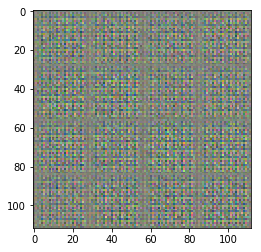

Epoch 1/1... Generator Loss: 1.8593 Discriminator Loss: 0.6150...
Epoch 1/1... Generator Loss: 3.5615 Discriminator Loss: 0.4140...
Epoch 1/1... Generator Loss: 2.3734 Discriminator Loss: 0.4849...
Epoch 1/1... Generator Loss: 1.4641 Discriminator Loss: 0.7802...
Epoch 1/1... Generator Loss: 2.7166 Discriminator Loss: 0.4505...
Epoch 1/1... Generator Loss: 3.5277 Discriminator Loss: 0.3793...
Epoch 1/1... Generator Loss: 3.4472 Discriminator Loss: 0.4341...
Epoch 1/1... Generator Loss: 5.3817 Discriminator Loss: 0.3979...
Epoch 1/1... Generator Loss: 5.7414 Discriminator Loss: 0.4402...
Epoch 1/1... Generator Loss: 1.5726 Discriminator Loss: 0.7391...


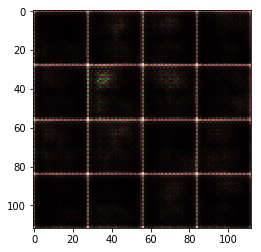

Epoch 1/1... Generator Loss: 2.8322 Discriminator Loss: 0.5633...
Epoch 1/1... Generator Loss: 2.5064 Discriminator Loss: 0.5456...
Epoch 1/1... Generator Loss: 7.1112 Discriminator Loss: 0.8161...
Epoch 1/1... Generator Loss: 2.7058 Discriminator Loss: 0.6959...
Epoch 1/1... Generator Loss: 3.2246 Discriminator Loss: 0.6163...
Epoch 1/1... Generator Loss: 0.3616 Discriminator Loss: 1.8802...
Epoch 1/1... Generator Loss: 0.7071 Discriminator Loss: 1.1579...
Epoch 1/1... Generator Loss: 3.4827 Discriminator Loss: 1.0348...
Epoch 1/1... Generator Loss: 2.7254 Discriminator Loss: 0.5122...
Epoch 1/1... Generator Loss: 2.8936 Discriminator Loss: 0.6508...


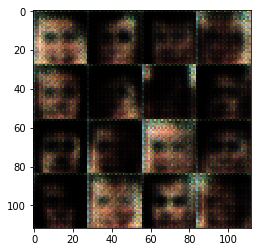

Epoch 1/1... Generator Loss: 3.9936 Discriminator Loss: 1.1883...
Epoch 1/1... Generator Loss: 0.9768 Discriminator Loss: 1.0857...
Epoch 1/1... Generator Loss: 1.0996 Discriminator Loss: 0.9807...
Epoch 1/1... Generator Loss: 3.1775 Discriminator Loss: 0.5181...
Epoch 1/1... Generator Loss: 2.0814 Discriminator Loss: 0.6310...
Epoch 1/1... Generator Loss: 0.3980 Discriminator Loss: 1.6953...
Epoch 1/1... Generator Loss: 0.7654 Discriminator Loss: 1.1745...
Epoch 1/1... Generator Loss: 1.4043 Discriminator Loss: 0.7153...
Epoch 1/1... Generator Loss: 2.8967 Discriminator Loss: 0.5097...
Epoch 1/1... Generator Loss: 0.9828 Discriminator Loss: 1.1624...


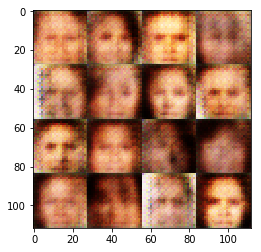

Epoch 1/1... Generator Loss: 1.0824 Discriminator Loss: 1.0073...
Epoch 1/1... Generator Loss: 0.3452 Discriminator Loss: 1.8110...
Epoch 1/1... Generator Loss: 1.3399 Discriminator Loss: 1.0724...
Epoch 1/1... Generator Loss: 0.8104 Discriminator Loss: 1.1865...
Epoch 1/1... Generator Loss: 1.0225 Discriminator Loss: 1.0225...
Epoch 1/1... Generator Loss: 1.5209 Discriminator Loss: 0.9003...
Epoch 1/1... Generator Loss: 1.4555 Discriminator Loss: 0.9782...
Epoch 1/1... Generator Loss: 0.9085 Discriminator Loss: 1.2004...
Epoch 1/1... Generator Loss: 1.6339 Discriminator Loss: 1.1012...
Epoch 1/1... Generator Loss: 0.9596 Discriminator Loss: 1.1294...


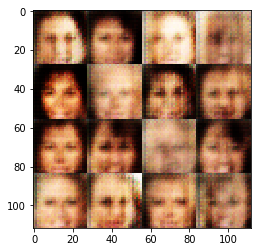

Epoch 1/1... Generator Loss: 1.0436 Discriminator Loss: 1.1725...
Epoch 1/1... Generator Loss: 0.9585 Discriminator Loss: 1.0461...
Epoch 1/1... Generator Loss: 0.9126 Discriminator Loss: 1.1905...
Epoch 1/1... Generator Loss: 1.2967 Discriminator Loss: 1.0413...
Epoch 1/1... Generator Loss: 1.1562 Discriminator Loss: 1.1040...
Epoch 1/1... Generator Loss: 0.8526 Discriminator Loss: 1.2938...
Epoch 1/1... Generator Loss: 1.7861 Discriminator Loss: 1.1981...
Epoch 1/1... Generator Loss: 1.4444 Discriminator Loss: 0.8690...
Epoch 1/1... Generator Loss: 0.9856 Discriminator Loss: 1.2943...
Epoch 1/1... Generator Loss: 0.7535 Discriminator Loss: 1.4867...


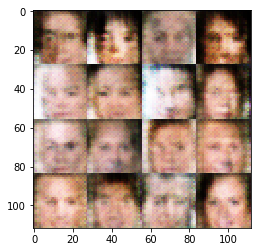

Epoch 1/1... Generator Loss: 1.7022 Discriminator Loss: 1.1388...
Epoch 1/1... Generator Loss: 1.1097 Discriminator Loss: 1.2402...
Epoch 1/1... Generator Loss: 0.8666 Discriminator Loss: 1.2576...
Epoch 1/1... Generator Loss: 0.8416 Discriminator Loss: 1.2080...
Epoch 1/1... Generator Loss: 0.9551 Discriminator Loss: 1.4303...
Epoch 1/1... Generator Loss: 0.7364 Discriminator Loss: 1.3864...
Epoch 1/1... Generator Loss: 0.7363 Discriminator Loss: 1.4048...
Epoch 1/1... Generator Loss: 1.2318 Discriminator Loss: 0.9609...
Epoch 1/1... Generator Loss: 0.8122 Discriminator Loss: 1.2584...
Epoch 1/1... Generator Loss: 0.5129 Discriminator Loss: 1.6395...


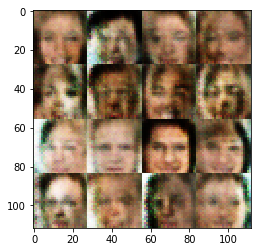

Epoch 1/1... Generator Loss: 1.0217 Discriminator Loss: 1.1447...
Epoch 1/1... Generator Loss: 0.7880 Discriminator Loss: 1.3180...
Epoch 1/1... Generator Loss: 0.8191 Discriminator Loss: 1.2528...
Epoch 1/1... Generator Loss: 0.6129 Discriminator Loss: 1.3786...
Epoch 1/1... Generator Loss: 1.1944 Discriminator Loss: 1.0657...
Epoch 1/1... Generator Loss: 0.9792 Discriminator Loss: 1.1721...
Epoch 1/1... Generator Loss: 0.8863 Discriminator Loss: 1.1715...
Epoch 1/1... Generator Loss: 0.9245 Discriminator Loss: 1.2106...
Epoch 1/1... Generator Loss: 0.7892 Discriminator Loss: 1.1708...
Epoch 1/1... Generator Loss: 0.9652 Discriminator Loss: 1.2214...


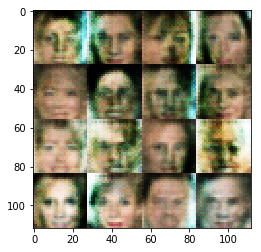

Epoch 1/1... Generator Loss: 0.9634 Discriminator Loss: 1.2855...
Epoch 1/1... Generator Loss: 0.8229 Discriminator Loss: 1.1471...
Epoch 1/1... Generator Loss: 0.7308 Discriminator Loss: 1.2892...
Epoch 1/1... Generator Loss: 0.7229 Discriminator Loss: 1.3999...
Epoch 1/1... Generator Loss: 1.0571 Discriminator Loss: 1.2116...
Epoch 1/1... Generator Loss: 0.8226 Discriminator Loss: 1.2322...
Epoch 1/1... Generator Loss: 0.9642 Discriminator Loss: 1.3014...
Epoch 1/1... Generator Loss: 1.0283 Discriminator Loss: 1.3309...
Epoch 1/1... Generator Loss: 0.7927 Discriminator Loss: 1.1671...
Epoch 1/1... Generator Loss: 0.4398 Discriminator Loss: 1.6246...


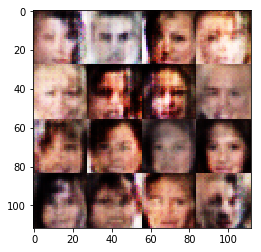

Epoch 1/1... Generator Loss: 1.3159 Discriminator Loss: 0.8279...
Epoch 1/1... Generator Loss: 0.7302 Discriminator Loss: 1.2525...
Epoch 1/1... Generator Loss: 0.9324 Discriminator Loss: 1.0411...
Epoch 1/1... Generator Loss: 1.7231 Discriminator Loss: 0.8376...
Epoch 1/1... Generator Loss: 0.8789 Discriminator Loss: 1.4680...
Epoch 1/1... Generator Loss: 0.7239 Discriminator Loss: 1.4823...
Epoch 1/1... Generator Loss: 0.8039 Discriminator Loss: 1.3295...
Epoch 1/1... Generator Loss: 0.7352 Discriminator Loss: 1.3211...
Epoch 1/1... Generator Loss: 1.5906 Discriminator Loss: 0.8409...
Epoch 1/1... Generator Loss: 2.6988 Discriminator Loss: 0.8314...


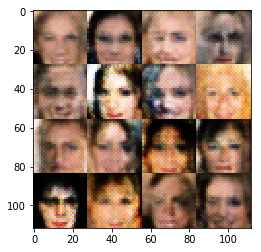

Epoch 1/1... Generator Loss: 0.7293 Discriminator Loss: 1.1440...
Epoch 1/1... Generator Loss: 1.2680 Discriminator Loss: 1.0697...
Epoch 1/1... Generator Loss: 0.7103 Discriminator Loss: 1.2049...
Epoch 1/1... Generator Loss: 1.4693 Discriminator Loss: 0.7355...
Epoch 1/1... Generator Loss: 0.5983 Discriminator Loss: 1.3092...
Epoch 1/1... Generator Loss: 3.7347 Discriminator Loss: 0.5842...
Epoch 1/1... Generator Loss: 1.0709 Discriminator Loss: 0.9485...
Epoch 1/1... Generator Loss: 3.2351 Discriminator Loss: 1.1132...
Epoch 1/1... Generator Loss: 0.9809 Discriminator Loss: 1.0366...
Epoch 1/1... Generator Loss: 1.5245 Discriminator Loss: 0.9222...


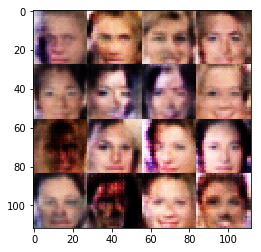

Epoch 1/1... Generator Loss: 0.4502 Discriminator Loss: 1.5078...
Epoch 1/1... Generator Loss: 0.4328 Discriminator Loss: 1.6181...
Epoch 1/1... Generator Loss: 1.5902 Discriminator Loss: 1.0461...
Epoch 1/1... Generator Loss: 3.1581 Discriminator Loss: 0.8639...
Epoch 1/1... Generator Loss: 1.2986 Discriminator Loss: 0.8703...
Epoch 1/1... Generator Loss: 1.3600 Discriminator Loss: 1.0140...
Epoch 1/1... Generator Loss: 2.9813 Discriminator Loss: 0.7665...
Epoch 1/1... Generator Loss: 0.9105 Discriminator Loss: 0.9660...
Epoch 1/1... Generator Loss: 0.8529 Discriminator Loss: 1.1749...
Epoch 1/1... Generator Loss: 0.6428 Discriminator Loss: 1.2804...


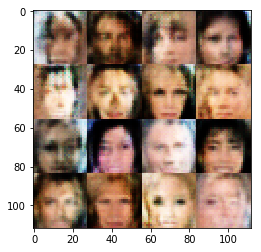

Epoch 1/1... Generator Loss: 3.4774 Discriminator Loss: 0.7486...
Epoch 1/1... Generator Loss: 0.5860 Discriminator Loss: 1.4017...
Epoch 1/1... Generator Loss: 0.7331 Discriminator Loss: 1.2264...
Epoch 1/1... Generator Loss: 0.8047 Discriminator Loss: 1.1730...
Epoch 1/1... Generator Loss: 1.7131 Discriminator Loss: 1.0581...
Epoch 1/1... Generator Loss: 0.8584 Discriminator Loss: 1.1578...
Epoch 1/1... Generator Loss: 0.5468 Discriminator Loss: 1.4278...
Epoch 1/1... Generator Loss: 0.5355 Discriminator Loss: 1.3398...
Epoch 1/1... Generator Loss: 1.1204 Discriminator Loss: 0.9489...
Epoch 1/1... Generator Loss: 1.1135 Discriminator Loss: 1.0473...


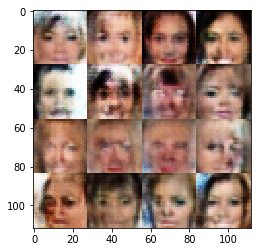

Epoch 1/1... Generator Loss: 0.7078 Discriminator Loss: 1.2324...
Epoch 1/1... Generator Loss: 0.6259 Discriminator Loss: 1.2862...
Epoch 1/1... Generator Loss: 0.7737 Discriminator Loss: 1.1626...
Epoch 1/1... Generator Loss: 0.6952 Discriminator Loss: 1.2155...
Epoch 1/1... Generator Loss: 0.6860 Discriminator Loss: 1.1943...
Epoch 1/1... Generator Loss: 0.2873 Discriminator Loss: 1.8726...
Epoch 1/1... Generator Loss: 1.2378 Discriminator Loss: 0.8987...
Epoch 1/1... Generator Loss: 0.6762 Discriminator Loss: 1.2460...
Epoch 1/1... Generator Loss: 1.4517 Discriminator Loss: 0.9933...
Epoch 1/1... Generator Loss: 1.3614 Discriminator Loss: 0.8548...


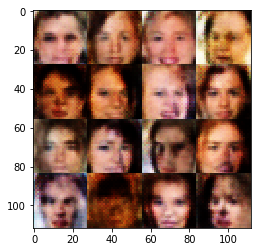

Epoch 1/1... Generator Loss: 0.8715 Discriminator Loss: 1.1964...
Epoch 1/1... Generator Loss: 1.3390 Discriminator Loss: 1.1625...
Epoch 1/1... Generator Loss: 0.7347 Discriminator Loss: 1.1941...
Epoch 1/1... Generator Loss: 1.7024 Discriminator Loss: 0.8601...
Epoch 1/1... Generator Loss: 1.9866 Discriminator Loss: 0.7349...
Epoch 1/1... Generator Loss: 1.3724 Discriminator Loss: 1.1657...
Epoch 1/1... Generator Loss: 0.9829 Discriminator Loss: 1.1060...
Epoch 1/1... Generator Loss: 0.6390 Discriminator Loss: 1.1846...
Epoch 1/1... Generator Loss: 1.2526 Discriminator Loss: 0.9848...
Epoch 1/1... Generator Loss: 0.7686 Discriminator Loss: 1.1290...


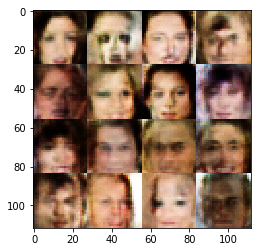

Epoch 1/1... Generator Loss: 0.9929 Discriminator Loss: 1.1214...
Epoch 1/1... Generator Loss: 0.7167 Discriminator Loss: 1.2165...
Epoch 1/1... Generator Loss: 0.7209 Discriminator Loss: 1.1811...
Epoch 1/1... Generator Loss: 0.3479 Discriminator Loss: 1.6785...
Epoch 1/1... Generator Loss: 1.1330 Discriminator Loss: 0.8783...
Epoch 1/1... Generator Loss: 1.5185 Discriminator Loss: 0.8976...
Epoch 1/1... Generator Loss: 0.5684 Discriminator Loss: 1.3160...
Epoch 1/1... Generator Loss: 1.8833 Discriminator Loss: 0.6369...
Epoch 1/1... Generator Loss: 2.1581 Discriminator Loss: 0.6820...
Epoch 1/1... Generator Loss: 1.5758 Discriminator Loss: 0.7926...


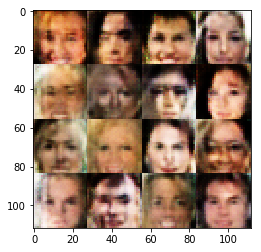

Epoch 1/1... Generator Loss: 3.9063 Discriminator Loss: 0.5655...
Epoch 1/1... Generator Loss: 1.2517 Discriminator Loss: 0.9919...
Epoch 1/1... Generator Loss: 2.0099 Discriminator Loss: 0.6051...
Epoch 1/1... Generator Loss: 1.2177 Discriminator Loss: 0.9151...
Epoch 1/1... Generator Loss: 0.8091 Discriminator Loss: 1.0890...
Epoch 1/1... Generator Loss: 1.2753 Discriminator Loss: 1.1279...
Epoch 1/1... Generator Loss: 0.2170 Discriminator Loss: 2.0948...
Epoch 1/1... Generator Loss: 1.0936 Discriminator Loss: 1.0264...
Epoch 1/1... Generator Loss: 0.7459 Discriminator Loss: 1.2820...
Epoch 1/1... Generator Loss: 1.6147 Discriminator Loss: 0.7751...


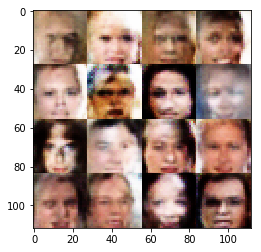

Epoch 1/1... Generator Loss: 0.7954 Discriminator Loss: 1.0801...
Epoch 1/1... Generator Loss: 0.4651 Discriminator Loss: 1.4619...
Epoch 1/1... Generator Loss: 1.4572 Discriminator Loss: 0.8581...
Epoch 1/1... Generator Loss: 2.3607 Discriminator Loss: 0.8085...
Epoch 1/1... Generator Loss: 1.1931 Discriminator Loss: 0.9691...
Epoch 1/1... Generator Loss: 0.2193 Discriminator Loss: 2.0625...
Epoch 1/1... Generator Loss: 0.7425 Discriminator Loss: 1.2792...
Epoch 1/1... Generator Loss: 0.8128 Discriminator Loss: 1.1911...
Epoch 1/1... Generator Loss: 0.4151 Discriminator Loss: 1.6169...
Epoch 1/1... Generator Loss: 1.5859 Discriminator Loss: 1.0565...


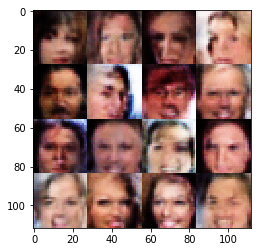

Epoch 1/1... Generator Loss: 2.8755 Discriminator Loss: 0.5999...
Epoch 1/1... Generator Loss: 1.4383 Discriminator Loss: 0.9116...
Epoch 1/1... Generator Loss: 0.3281 Discriminator Loss: 1.7303...
Epoch 1/1... Generator Loss: 1.7159 Discriminator Loss: 0.8183...
Epoch 1/1... Generator Loss: 1.1394 Discriminator Loss: 1.1881...
Epoch 1/1... Generator Loss: 1.1450 Discriminator Loss: 1.3226...
Epoch 1/1... Generator Loss: 1.1894 Discriminator Loss: 1.2162...
Epoch 1/1... Generator Loss: 2.2953 Discriminator Loss: 0.7195...
Epoch 1/1... Generator Loss: 1.5842 Discriminator Loss: 0.7951...
Epoch 1/1... Generator Loss: 2.0461 Discriminator Loss: 0.5490...


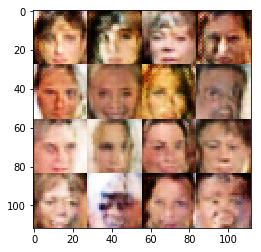

Epoch 1/1... Generator Loss: 0.9508 Discriminator Loss: 0.9301...
Epoch 1/1... Generator Loss: 0.5313 Discriminator Loss: 1.5961...
Epoch 1/1... Generator Loss: 0.6483 Discriminator Loss: 1.2351...
Epoch 1/1... Generator Loss: 0.9808 Discriminator Loss: 1.1250...
Epoch 1/1... Generator Loss: 1.3518 Discriminator Loss: 0.9930...
Epoch 1/1... Generator Loss: 1.3507 Discriminator Loss: 0.7468...
Epoch 1/1... Generator Loss: 2.5838 Discriminator Loss: 0.6607...
Epoch 1/1... Generator Loss: 3.1571 Discriminator Loss: 0.5830...
Epoch 1/1... Generator Loss: 1.6966 Discriminator Loss: 0.8522...
Epoch 1/1... Generator Loss: 0.6971 Discriminator Loss: 1.2480...


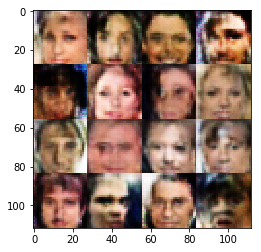

Epoch 1/1... Generator Loss: 0.7596 Discriminator Loss: 1.1966...
Epoch 1/1... Generator Loss: 2.2829 Discriminator Loss: 0.7550...
Epoch 1/1... Generator Loss: 1.1033 Discriminator Loss: 1.0276...
Epoch 1/1... Generator Loss: 1.0203 Discriminator Loss: 1.3783...
Epoch 1/1... Generator Loss: 0.8590 Discriminator Loss: 1.1913...
Epoch 1/1... Generator Loss: 0.7479 Discriminator Loss: 1.1787...
Epoch 1/1... Generator Loss: 1.1406 Discriminator Loss: 0.8076...
Epoch 1/1... Generator Loss: 1.2844 Discriminator Loss: 0.8321...
Epoch 1/1... Generator Loss: 1.4471 Discriminator Loss: 0.8317...
Epoch 1/1... Generator Loss: 0.7169 Discriminator Loss: 1.1777...


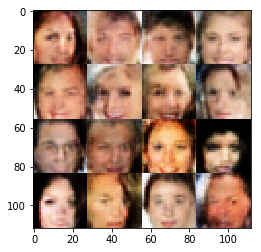

Epoch 1/1... Generator Loss: 0.8478 Discriminator Loss: 1.0502...
Epoch 1/1... Generator Loss: 1.0127 Discriminator Loss: 1.0201...
Epoch 1/1... Generator Loss: 0.2913 Discriminator Loss: 1.8435...
Epoch 1/1... Generator Loss: 3.0372 Discriminator Loss: 0.6854...
Epoch 1/1... Generator Loss: 0.8378 Discriminator Loss: 1.1094...
Epoch 1/1... Generator Loss: 2.2293 Discriminator Loss: 0.5462...
Epoch 1/1... Generator Loss: 0.6470 Discriminator Loss: 1.2780...
Epoch 1/1... Generator Loss: 0.2327 Discriminator Loss: 2.0324...
Epoch 1/1... Generator Loss: 0.6515 Discriminator Loss: 1.2124...
Epoch 1/1... Generator Loss: 0.8036 Discriminator Loss: 1.1440...


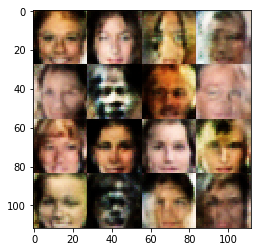

Epoch 1/1... Generator Loss: 1.1308 Discriminator Loss: 0.9554...
Epoch 1/1... Generator Loss: 1.1608 Discriminator Loss: 0.8551...
Epoch 1/1... Generator Loss: 1.3104 Discriminator Loss: 0.7512...
Epoch 1/1... Generator Loss: 1.0027 Discriminator Loss: 0.9217...
Epoch 1/1... Generator Loss: 1.3955 Discriminator Loss: 0.7195...
Epoch 1/1... Generator Loss: 0.7136 Discriminator Loss: 1.0916...
Epoch 1/1... Generator Loss: 0.6253 Discriminator Loss: 1.3214...
Epoch 1/1... Generator Loss: 0.4171 Discriminator Loss: 1.7208...
Epoch 1/1... Generator Loss: 0.8147 Discriminator Loss: 1.4046...
Epoch 1/1... Generator Loss: 0.9166 Discriminator Loss: 0.9372...


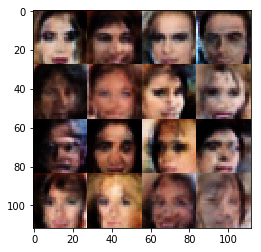

Epoch 1/1... Generator Loss: 0.5584 Discriminator Loss: 1.4851...
Epoch 1/1... Generator Loss: 0.5403 Discriminator Loss: 1.3523...
Epoch 1/1... Generator Loss: 1.6389 Discriminator Loss: 0.6969...
Epoch 1/1... Generator Loss: 2.1115 Discriminator Loss: 0.6130...
Epoch 1/1... Generator Loss: 0.8593 Discriminator Loss: 1.0250...
Epoch 1/1... Generator Loss: 1.2986 Discriminator Loss: 1.1650...
Epoch 1/1... Generator Loss: 1.2603 Discriminator Loss: 0.8537...
Epoch 1/1... Generator Loss: 1.5143 Discriminator Loss: 1.3795...
Epoch 1/1... Generator Loss: 1.8111 Discriminator Loss: 0.9129...
Epoch 1/1... Generator Loss: 1.3375 Discriminator Loss: 0.7585...


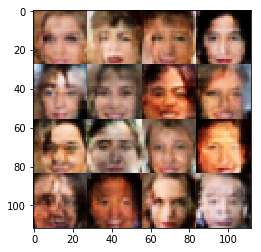

Epoch 1/1... Generator Loss: 1.4314 Discriminator Loss: 1.2927...
Epoch 1/1... Generator Loss: 0.8654 Discriminator Loss: 0.9713...
Epoch 1/1... Generator Loss: 0.9453 Discriminator Loss: 1.0055...
Epoch 1/1... Generator Loss: 1.3775 Discriminator Loss: 0.7625...
Epoch 1/1... Generator Loss: 0.7617 Discriminator Loss: 1.0620...
Epoch 1/1... Generator Loss: 0.6571 Discriminator Loss: 1.4449...
Epoch 1/1... Generator Loss: 1.2957 Discriminator Loss: 0.8176...
Epoch 1/1... Generator Loss: 1.4796 Discriminator Loss: 0.9363...
Epoch 1/1... Generator Loss: 1.1004 Discriminator Loss: 0.8491...
Epoch 1/1... Generator Loss: 0.4724 Discriminator Loss: 1.9017...


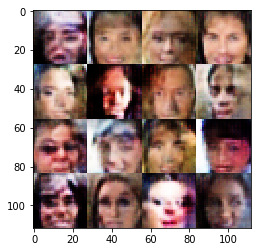

Epoch 1/1... Generator Loss: 0.6086 Discriminator Loss: 1.2672...
Epoch 1/1... Generator Loss: 0.8885 Discriminator Loss: 1.2416...
Epoch 1/1... Generator Loss: 1.4637 Discriminator Loss: 0.8804...
Epoch 1/1... Generator Loss: 1.4781 Discriminator Loss: 0.9722...
Epoch 1/1... Generator Loss: 0.9880 Discriminator Loss: 1.0824...
Epoch 1/1... Generator Loss: 1.4975 Discriminator Loss: 0.8126...
Epoch 1/1... Generator Loss: 1.1495 Discriminator Loss: 0.9527...
Epoch 1/1... Generator Loss: 0.8351 Discriminator Loss: 1.0414...
Epoch 1/1... Generator Loss: 0.6566 Discriminator Loss: 1.2519...
Epoch 1/1... Generator Loss: 1.1271 Discriminator Loss: 0.9063...


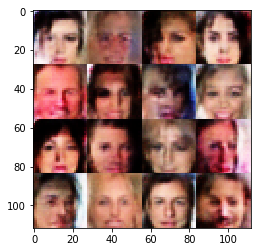

Epoch 1/1... Generator Loss: 3.9157 Discriminator Loss: 0.6434...
Epoch 1/1... Generator Loss: 0.3960 Discriminator Loss: 1.6496...
Epoch 1/1... Generator Loss: 1.9156 Discriminator Loss: 0.9340...
Epoch 1/1... Generator Loss: 1.6022 Discriminator Loss: 0.7876...
Epoch 1/1... Generator Loss: 4.0733 Discriminator Loss: 0.5914...
Epoch 1/1... Generator Loss: 2.2459 Discriminator Loss: 1.1808...
Epoch 1/1... Generator Loss: 2.1330 Discriminator Loss: 0.8337...
Epoch 1/1... Generator Loss: 1.3594 Discriminator Loss: 0.9994...
Epoch 1/1... Generator Loss: 0.9181 Discriminator Loss: 0.9734...
Epoch 1/1... Generator Loss: 0.4502 Discriminator Loss: 1.5959...


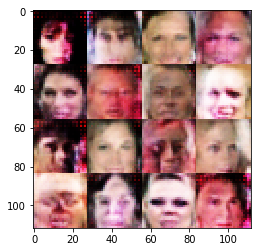

Epoch 1/1... Generator Loss: 0.9513 Discriminator Loss: 0.9617...
Epoch 1/1... Generator Loss: 1.0429 Discriminator Loss: 0.9123...
Epoch 1/1... Generator Loss: 0.7450 Discriminator Loss: 1.2115...
Epoch 1/1... Generator Loss: 1.6239 Discriminator Loss: 0.9285...
Epoch 1/1... Generator Loss: 0.6340 Discriminator Loss: 1.2930...
Epoch 1/1... Generator Loss: 0.8112 Discriminator Loss: 1.2948...
Epoch 1/1... Generator Loss: 1.9092 Discriminator Loss: 0.5914...
Epoch 1/1... Generator Loss: 1.4972 Discriminator Loss: 0.7080...
Epoch 1/1... Generator Loss: 1.7533 Discriminator Loss: 0.7780...
Epoch 1/1... Generator Loss: 0.5771 Discriminator Loss: 1.2844...


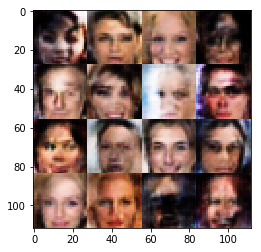

Epoch 1/1... Generator Loss: 1.1296 Discriminator Loss: 0.8717...
Epoch 1/1... Generator Loss: 1.0462 Discriminator Loss: 0.8726...
Epoch 1/1... Generator Loss: 0.9661 Discriminator Loss: 0.8806...
Epoch 1/1... Generator Loss: 0.8246 Discriminator Loss: 1.0219...
Epoch 1/1... Generator Loss: 1.8350 Discriminator Loss: 0.6335...
Epoch 1/1... Generator Loss: 1.8664 Discriminator Loss: 0.6842...
Epoch 1/1... Generator Loss: 0.4552 Discriminator Loss: 1.5201...
Epoch 1/1... Generator Loss: 0.6989 Discriminator Loss: 1.1502...
Epoch 1/1... Generator Loss: 1.9009 Discriminator Loss: 0.6696...
Epoch 1/1... Generator Loss: 3.9300 Discriminator Loss: 1.9435...


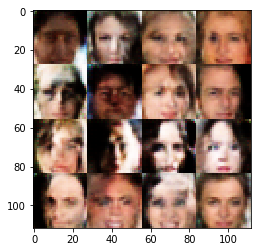

Epoch 1/1... Generator Loss: 0.6634 Discriminator Loss: 1.3567...
Epoch 1/1... Generator Loss: 0.4550 Discriminator Loss: 1.4632...
Epoch 1/1... Generator Loss: 0.7443 Discriminator Loss: 1.1347...
Epoch 1/1... Generator Loss: 0.6206 Discriminator Loss: 1.1693...
Epoch 1/1... Generator Loss: 2.2563 Discriminator Loss: 0.5590...
Epoch 1/1... Generator Loss: 1.7059 Discriminator Loss: 0.5859...
Epoch 1/1... Generator Loss: 1.6918 Discriminator Loss: 0.6545...
Epoch 1/1... Generator Loss: 0.5142 Discriminator Loss: 1.5450...
Epoch 1/1... Generator Loss: 1.4460 Discriminator Loss: 1.6393...
Epoch 1/1... Generator Loss: 1.8231 Discriminator Loss: 0.8336...


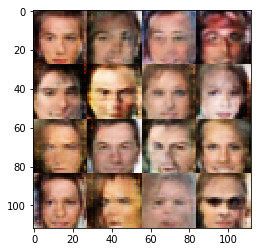

Epoch 1/1... Generator Loss: 0.7346 Discriminator Loss: 1.2010...
Epoch 1/1... Generator Loss: 1.4131 Discriminator Loss: 0.9760...
Epoch 1/1... Generator Loss: 1.0114 Discriminator Loss: 1.3481...
Epoch 1/1... Generator Loss: 1.7498 Discriminator Loss: 0.7304...
Epoch 1/1... Generator Loss: 1.0016 Discriminator Loss: 0.9498...
Epoch 1/1... Generator Loss: 1.7006 Discriminator Loss: 0.7631...
Epoch 1/1... Generator Loss: 1.2948 Discriminator Loss: 0.7916...
Epoch 1/1... Generator Loss: 0.6267 Discriminator Loss: 1.2660...
Epoch 1/1... Generator Loss: 2.6295 Discriminator Loss: 0.8130...
Epoch 1/1... Generator Loss: 1.0413 Discriminator Loss: 1.0099...


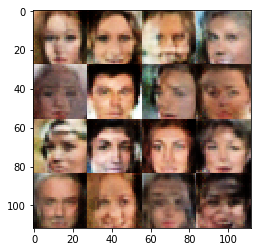

Epoch 1/1... Generator Loss: 2.0540 Discriminator Loss: 0.5463...
Epoch 1/1... Generator Loss: 0.6025 Discriminator Loss: 1.2800...
Epoch 1/1... Generator Loss: 2.3811 Discriminator Loss: 0.9201...
Epoch 1/1... Generator Loss: 1.8020 Discriminator Loss: 0.5952...
Epoch 1/1... Generator Loss: 1.0015 Discriminator Loss: 1.2370...
Epoch 1/1... Generator Loss: 1.3187 Discriminator Loss: 0.8066...
Epoch 1/1... Generator Loss: 3.0016 Discriminator Loss: 0.5600...
Epoch 1/1... Generator Loss: 0.5979 Discriminator Loss: 1.2270...
Epoch 1/1... Generator Loss: 3.1727 Discriminator Loss: 0.4296...
Epoch 1/1... Generator Loss: 1.2325 Discriminator Loss: 1.0434...


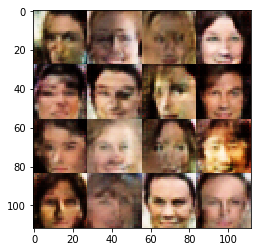

Epoch 1/1... Generator Loss: 1.0450 Discriminator Loss: 1.0940...
Epoch 1/1... Generator Loss: 0.8603 Discriminator Loss: 1.1733...
Epoch 1/1... Generator Loss: 0.7575 Discriminator Loss: 1.2581...
Epoch 1/1... Generator Loss: 0.8855 Discriminator Loss: 1.1097...
Epoch 1/1... Generator Loss: 2.8863 Discriminator Loss: 1.4496...
Epoch 1/1... Generator Loss: 2.1275 Discriminator Loss: 0.9466...
Epoch 1/1... Generator Loss: 1.8086 Discriminator Loss: 0.8342...
Epoch 1/1... Generator Loss: 1.2739 Discriminator Loss: 0.8880...
Epoch 1/1... Generator Loss: 1.1323 Discriminator Loss: 0.8651...
Epoch 1/1... Generator Loss: 1.8912 Discriminator Loss: 1.0475...


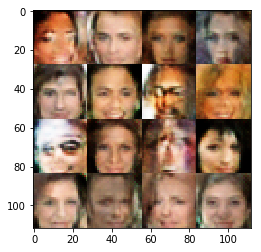

Epoch 1/1... Generator Loss: 2.0373 Discriminator Loss: 0.6094...
Epoch 1/1... Generator Loss: 1.2572 Discriminator Loss: 0.8306...
Epoch 1/1... Generator Loss: 3.8674 Discriminator Loss: 0.5659...
Epoch 1/1... Generator Loss: 2.4101 Discriminator Loss: 0.7006...
Epoch 1/1... Generator Loss: 1.7493 Discriminator Loss: 0.6426...
Epoch 1/1... Generator Loss: 0.6899 Discriminator Loss: 1.1840...
Epoch 1/1... Generator Loss: 0.7176 Discriminator Loss: 1.3077...
Epoch 1/1... Generator Loss: 1.1669 Discriminator Loss: 0.8900...
Epoch 1/1... Generator Loss: 1.4565 Discriminator Loss: 0.8476...
Epoch 1/1... Generator Loss: 1.2215 Discriminator Loss: 0.8726...


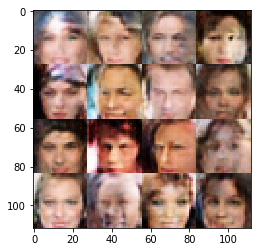

Epoch 1/1... Generator Loss: 0.5330 Discriminator Loss: 1.4466...
Epoch 1/1... Generator Loss: 1.1061 Discriminator Loss: 1.0273...
Epoch 1/1... Generator Loss: 1.5761 Discriminator Loss: 0.8420...
Epoch 1/1... Generator Loss: 1.6569 Discriminator Loss: 0.7511...
Epoch 1/1... Generator Loss: 1.1487 Discriminator Loss: 0.9572...
Epoch 1/1... Generator Loss: 1.5681 Discriminator Loss: 1.0331...
Epoch 1/1... Generator Loss: 1.1886 Discriminator Loss: 0.9981...
Epoch 1/1... Generator Loss: 1.5020 Discriminator Loss: 0.9801...
Epoch 1/1... Generator Loss: 0.8156 Discriminator Loss: 1.0193...
Epoch 1/1... Generator Loss: 1.2479 Discriminator Loss: 0.8878...


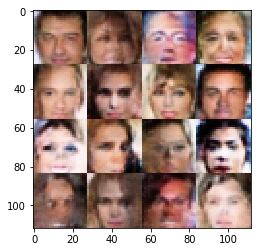

Epoch 1/1... Generator Loss: 0.8614 Discriminator Loss: 0.9842...
Epoch 1/1... Generator Loss: 2.2204 Discriminator Loss: 0.7219...
Epoch 1/1... Generator Loss: 2.2257 Discriminator Loss: 0.5745...
Epoch 1/1... Generator Loss: 0.9279 Discriminator Loss: 1.0215...
Epoch 1/1... Generator Loss: 0.4489 Discriminator Loss: 1.4696...
Epoch 1/1... Generator Loss: 1.4932 Discriminator Loss: 0.7157...
Epoch 1/1... Generator Loss: 2.6019 Discriminator Loss: 0.9150...
Epoch 1/1... Generator Loss: 1.2807 Discriminator Loss: 0.7878...
Epoch 1/1... Generator Loss: 0.5993 Discriminator Loss: 1.3525...
Epoch 1/1... Generator Loss: 2.1633 Discriminator Loss: 0.9157...


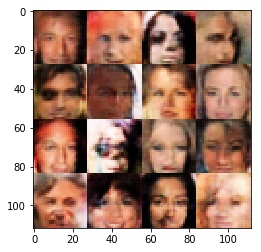

Epoch 1/1... Generator Loss: 1.0150 Discriminator Loss: 0.8454...
Epoch 1/1... Generator Loss: 1.7393 Discriminator Loss: 1.4316...
Epoch 1/1... Generator Loss: 0.7513 Discriminator Loss: 1.1418...
Epoch 1/1... Generator Loss: 0.9982 Discriminator Loss: 1.1778...
Epoch 1/1... Generator Loss: 0.6825 Discriminator Loss: 1.1875...
Epoch 1/1... Generator Loss: 0.3226 Discriminator Loss: 1.8267...
Epoch 1/1... Generator Loss: 1.1893 Discriminator Loss: 0.8128...
Epoch 1/1... Generator Loss: 1.1328 Discriminator Loss: 0.8882...
Epoch 1/1... Generator Loss: 0.3871 Discriminator Loss: 1.6059...
Epoch 1/1... Generator Loss: 0.5969 Discriminator Loss: 1.3223...


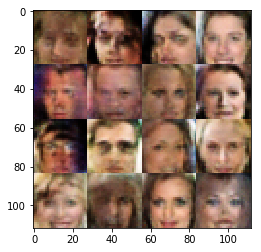

Epoch 1/1... Generator Loss: 0.5320 Discriminator Loss: 1.3925...
Epoch 1/1... Generator Loss: 1.7113 Discriminator Loss: 0.6677...
Epoch 1/1... Generator Loss: 0.4660 Discriminator Loss: 1.4597...
Epoch 1/1... Generator Loss: 1.3364 Discriminator Loss: 0.7636...
Epoch 1/1... Generator Loss: 0.4770 Discriminator Loss: 1.4058...
Epoch 1/1... Generator Loss: 2.2020 Discriminator Loss: 0.8096...
Epoch 1/1... Generator Loss: 1.9681 Discriminator Loss: 0.6596...
Epoch 1/1... Generator Loss: 1.6850 Discriminator Loss: 0.7790...
Epoch 1/1... Generator Loss: 0.9884 Discriminator Loss: 1.1264...
Epoch 1/1... Generator Loss: 1.6931 Discriminator Loss: 0.7983...


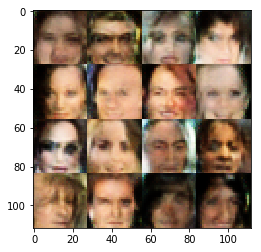

Epoch 1/1... Generator Loss: 0.5638 Discriminator Loss: 1.3433...
Epoch 1/1... Generator Loss: 2.8553 Discriminator Loss: 0.8127...
Epoch 1/1... Generator Loss: 0.5124 Discriminator Loss: 1.4846...
Epoch 1/1... Generator Loss: 1.2224 Discriminator Loss: 0.9886...
Epoch 1/1... Generator Loss: 0.5424 Discriminator Loss: 1.3426...
Epoch 1/1... Generator Loss: 0.8754 Discriminator Loss: 1.0776...
Epoch 1/1... Generator Loss: 0.7450 Discriminator Loss: 1.2109...
Epoch 1/1... Generator Loss: 1.5886 Discriminator Loss: 0.7128...
Epoch 1/1... Generator Loss: 0.8597 Discriminator Loss: 1.1330...
Epoch 1/1... Generator Loss: 1.0292 Discriminator Loss: 1.0806...


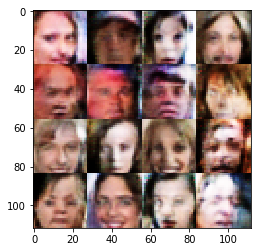

Epoch 1/1... Generator Loss: 0.7032 Discriminator Loss: 1.3143...
Epoch 1/1... Generator Loss: 1.0227 Discriminator Loss: 1.2950...
Epoch 1/1... Generator Loss: 1.3014 Discriminator Loss: 0.9898...
Epoch 1/1... Generator Loss: 0.6104 Discriminator Loss: 1.2339...
Epoch 1/1... Generator Loss: 1.4885 Discriminator Loss: 0.6723...
Epoch 1/1... Generator Loss: 0.9736 Discriminator Loss: 1.0588...
Epoch 1/1... Generator Loss: 0.4549 Discriminator Loss: 1.4643...
Epoch 1/1... Generator Loss: 1.0204 Discriminator Loss: 0.9703...
Epoch 1/1... Generator Loss: 0.8416 Discriminator Loss: 1.0305...
Epoch 1/1... Generator Loss: 1.1254 Discriminator Loss: 1.0407...


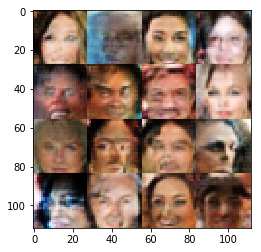

Epoch 1/1... Generator Loss: 1.8237 Discriminator Loss: 0.7574...
Epoch 1/1... Generator Loss: 1.5199 Discriminator Loss: 1.3195...
Epoch 1/1... Generator Loss: 0.7487 Discriminator Loss: 1.1425...
Epoch 1/1... Generator Loss: 0.8048 Discriminator Loss: 1.6553...
Epoch 1/1... Generator Loss: 1.6655 Discriminator Loss: 0.6667...
Epoch 1/1... Generator Loss: 1.3865 Discriminator Loss: 1.0896...
Epoch 1/1... Generator Loss: 1.6992 Discriminator Loss: 0.6331...
Epoch 1/1... Generator Loss: 1.0722 Discriminator Loss: 1.0923...
Epoch 1/1... Generator Loss: 1.0508 Discriminator Loss: 1.0975...
Epoch 1/1... Generator Loss: 1.3142 Discriminator Loss: 1.0517...


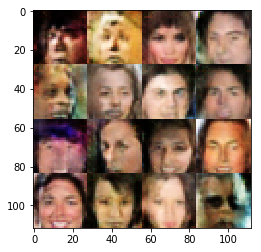

Epoch 1/1... Generator Loss: 1.7996 Discriminator Loss: 0.8743...
Epoch 1/1... Generator Loss: 1.0347 Discriminator Loss: 1.4371...
Epoch 1/1... Generator Loss: 1.2154 Discriminator Loss: 0.9408...
Epoch 1/1... Generator Loss: 2.5162 Discriminator Loss: 0.6769...
Epoch 1/1... Generator Loss: 2.1238 Discriminator Loss: 0.5984...
Epoch 1/1... Generator Loss: 1.2099 Discriminator Loss: 0.8858...
Epoch 1/1... Generator Loss: 0.5254 Discriminator Loss: 1.4113...
Epoch 1/1... Generator Loss: 0.7870 Discriminator Loss: 1.1618...
Epoch 1/1... Generator Loss: 0.9903 Discriminator Loss: 0.9181...
Epoch 1/1... Generator Loss: 0.6913 Discriminator Loss: 1.1484...


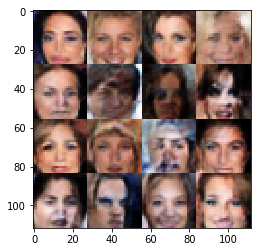

Epoch 1/1... Generator Loss: 1.0548 Discriminator Loss: 0.9199...
Epoch 1/1... Generator Loss: 0.7573 Discriminator Loss: 1.3139...
Epoch 1/1... Generator Loss: 1.1098 Discriminator Loss: 0.8401...
Epoch 1/1... Generator Loss: 0.6281 Discriminator Loss: 1.2911...
Epoch 1/1... Generator Loss: 0.9840 Discriminator Loss: 0.9525...
Epoch 1/1... Generator Loss: 1.1634 Discriminator Loss: 0.8652...
Epoch 1/1... Generator Loss: 0.7180 Discriminator Loss: 1.1831...
Epoch 1/1... Generator Loss: 3.3132 Discriminator Loss: 0.6104...
Epoch 1/1... Generator Loss: 0.5794 Discriminator Loss: 1.3895...
Epoch 1/1... Generator Loss: 1.5132 Discriminator Loss: 1.3569...


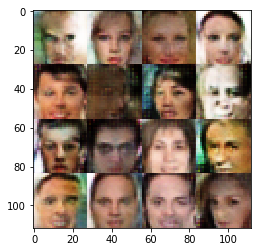

Epoch 1/1... Generator Loss: 1.4038 Discriminator Loss: 0.8105...
Epoch 1/1... Generator Loss: 1.1303 Discriminator Loss: 0.8947...
Epoch 1/1... Generator Loss: 1.4920 Discriminator Loss: 1.3878...
Epoch 1/1... Generator Loss: 0.7642 Discriminator Loss: 1.1258...
Epoch 1/1... Generator Loss: 1.9140 Discriminator Loss: 0.7568...
Epoch 1/1... Generator Loss: 1.1595 Discriminator Loss: 1.0620...
Epoch 1/1... Generator Loss: 1.6952 Discriminator Loss: 1.3639...
Epoch 1/1... Generator Loss: 1.8920 Discriminator Loss: 0.6159...
Epoch 1/1... Generator Loss: 2.8076 Discriminator Loss: 0.4832...
Epoch 1/1... Generator Loss: 0.6080 Discriminator Loss: 1.2740...


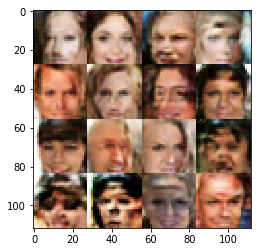

Epoch 1/1... Generator Loss: 0.7087 Discriminator Loss: 1.2270...
Epoch 1/1... Generator Loss: 1.3975 Discriminator Loss: 0.8340...
Epoch 1/1... Generator Loss: 0.4755 Discriminator Loss: 1.6119...
Epoch 1/1... Generator Loss: 0.2705 Discriminator Loss: 1.9919...
Epoch 1/1... Generator Loss: 5.1786 Discriminator Loss: 0.4328...
Epoch 1/1... Generator Loss: 1.6907 Discriminator Loss: 0.6657...
Epoch 1/1... Generator Loss: 1.1350 Discriminator Loss: 0.8356...
Epoch 1/1... Generator Loss: 1.9451 Discriminator Loss: 0.7405...
Epoch 1/1... Generator Loss: 0.6609 Discriminator Loss: 1.2859...
Epoch 1/1... Generator Loss: 1.8622 Discriminator Loss: 0.8210...


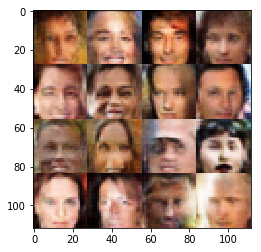

Epoch 1/1... Generator Loss: 0.8398 Discriminator Loss: 0.9816...
Epoch 1/1... Generator Loss: 0.5196 Discriminator Loss: 1.4081...
Epoch 1/1... Generator Loss: 2.5933 Discriminator Loss: 0.5589...
Epoch 1/1... Generator Loss: 1.9434 Discriminator Loss: 0.5627...
Epoch 1/1... Generator Loss: 1.1432 Discriminator Loss: 1.0762...
Epoch 1/1... Generator Loss: 0.5576 Discriminator Loss: 1.4719...
Epoch 1/1... Generator Loss: 1.5899 Discriminator Loss: 0.6902...
Epoch 1/1... Generator Loss: 3.6794 Discriminator Loss: 0.7051...
Epoch 1/1... Generator Loss: 0.9938 Discriminator Loss: 0.9489...
Epoch 1/1... Generator Loss: 0.9639 Discriminator Loss: 1.0414...


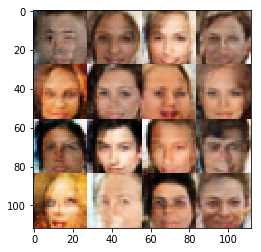

Epoch 1/1... Generator Loss: 0.6967 Discriminator Loss: 1.3656...
Epoch 1/1... Generator Loss: 1.0681 Discriminator Loss: 1.1529...
Epoch 1/1... Generator Loss: 0.9874 Discriminator Loss: 0.9290...
Epoch 1/1... Generator Loss: 0.8646 Discriminator Loss: 0.9851...
Epoch 1/1... Generator Loss: 1.1166 Discriminator Loss: 0.8994...
Epoch 1/1... Generator Loss: 1.0556 Discriminator Loss: 0.9609...
Epoch 1/1... Generator Loss: 0.6147 Discriminator Loss: 1.6452...
Epoch 1/1... Generator Loss: 1.1382 Discriminator Loss: 0.8926...
Epoch 1/1... Generator Loss: 1.4091 Discriminator Loss: 0.8140...
Epoch 1/1... Generator Loss: 0.5751 Discriminator Loss: 1.4567...


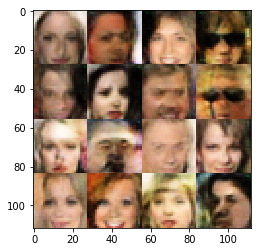

Epoch 1/1... Generator Loss: 0.1762 Discriminator Loss: 2.3407...
Epoch 1/1... Generator Loss: 1.1758 Discriminator Loss: 0.9819...
Epoch 1/1... Generator Loss: 0.6145 Discriminator Loss: 1.3087...
Epoch 1/1... Generator Loss: 1.5221 Discriminator Loss: 1.2202...
Epoch 1/1... Generator Loss: 0.9592 Discriminator Loss: 1.0334...
Epoch 1/1... Generator Loss: 0.5536 Discriminator Loss: 1.3149...
Epoch 1/1... Generator Loss: 0.8953 Discriminator Loss: 1.3753...
Epoch 1/1... Generator Loss: 1.7213 Discriminator Loss: 0.6896...
Epoch 1/1... Generator Loss: 0.8336 Discriminator Loss: 1.0574...
Epoch 1/1... Generator Loss: 0.6299 Discriminator Loss: 1.2794...


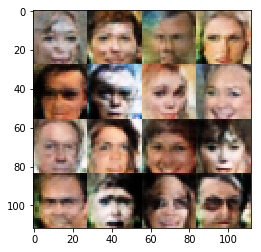

Epoch 1/1... Generator Loss: 0.8570 Discriminator Loss: 1.2509...
Epoch 1/1... Generator Loss: 1.1519 Discriminator Loss: 1.0964...
Epoch 1/1... Generator Loss: 0.8665 Discriminator Loss: 1.0808...
Epoch 1/1... Generator Loss: 1.3869 Discriminator Loss: 0.8822...
Epoch 1/1... Generator Loss: 0.9482 Discriminator Loss: 1.0618...
Epoch 1/1... Generator Loss: 0.5234 Discriminator Loss: 1.4460...
Epoch 1/1... Generator Loss: 1.5078 Discriminator Loss: 0.7403...
Epoch 1/1... Generator Loss: 0.4844 Discriminator Loss: 1.3605...
Epoch 1/1... Generator Loss: 0.8417 Discriminator Loss: 1.0346...
Epoch 1/1... Generator Loss: 2.0035 Discriminator Loss: 0.6644...


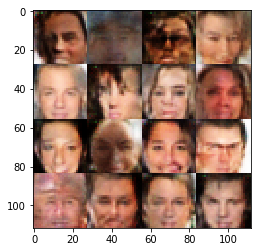

Epoch 1/1... Generator Loss: 1.6511 Discriminator Loss: 0.6380...
Epoch 1/1... Generator Loss: 1.3499 Discriminator Loss: 0.8731...
Epoch 1/1... Generator Loss: 0.7733 Discriminator Loss: 1.1016...
Epoch 1/1... Generator Loss: 1.1416 Discriminator Loss: 0.9801...
Epoch 1/1... Generator Loss: 3.4207 Discriminator Loss: 0.4288...
Epoch 1/1... Generator Loss: 0.7976 Discriminator Loss: 1.0693...
Epoch 1/1... Generator Loss: 0.6338 Discriminator Loss: 1.4234...
Epoch 1/1... Generator Loss: 2.6923 Discriminator Loss: 0.6551...
Epoch 1/1... Generator Loss: 0.8057 Discriminator Loss: 1.1683...
Epoch 1/1... Generator Loss: 2.1437 Discriminator Loss: 0.5802...


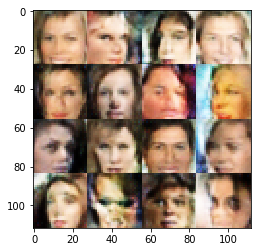

Epoch 1/1... Generator Loss: 1.2861 Discriminator Loss: 0.7842...
Epoch 1/1... Generator Loss: 0.8480 Discriminator Loss: 1.2058...
Epoch 1/1... Generator Loss: 0.7153 Discriminator Loss: 1.1395...
Epoch 1/1... Generator Loss: 1.7340 Discriminator Loss: 0.7442...
Epoch 1/1... Generator Loss: 2.0123 Discriminator Loss: 0.5788...
Epoch 1/1... Generator Loss: 0.7483 Discriminator Loss: 1.1956...
Epoch 1/1... Generator Loss: 0.8748 Discriminator Loss: 1.1165...
Epoch 1/1... Generator Loss: 1.7074 Discriminator Loss: 0.7355...
Epoch 1/1... Generator Loss: 0.9658 Discriminator Loss: 0.9854...
Epoch 1/1... Generator Loss: 1.8011 Discriminator Loss: 0.5562...


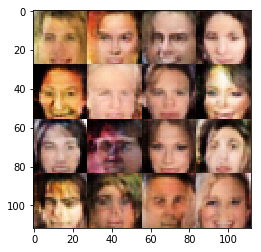

Epoch 1/1... Generator Loss: 0.8493 Discriminator Loss: 1.0705...
Epoch 1/1... Generator Loss: 1.8358 Discriminator Loss: 0.6725...
Epoch 1/1... Generator Loss: 0.2629 Discriminator Loss: 2.2814...
Epoch 1/1... Generator Loss: 0.6105 Discriminator Loss: 1.5136...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.0999...
Epoch 1/1... Generator Loss: 1.0430 Discriminator Loss: 0.9589...
Epoch 1/1... Generator Loss: 1.4941 Discriminator Loss: 0.8655...
Epoch 1/1... Generator Loss: 0.6066 Discriminator Loss: 1.3858...
Epoch 1/1... Generator Loss: 1.5622 Discriminator Loss: 0.9456...
Epoch 1/1... Generator Loss: 1.4447 Discriminator Loss: 0.8716...


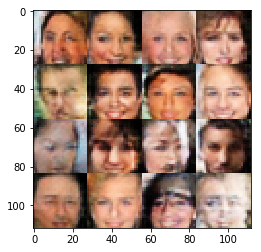

Epoch 1/1... Generator Loss: 0.8761 Discriminator Loss: 1.1973...
Epoch 1/1... Generator Loss: 1.9124 Discriminator Loss: 0.7094...
Epoch 1/1... Generator Loss: 0.5290 Discriminator Loss: 1.5685...
Epoch 1/1... Generator Loss: 0.7057 Discriminator Loss: 1.3464...
Epoch 1/1... Generator Loss: 1.7186 Discriminator Loss: 0.9625...
Epoch 1/1... Generator Loss: 1.2354 Discriminator Loss: 0.8543...
Epoch 1/1... Generator Loss: 0.8793 Discriminator Loss: 1.0122...
Epoch 1/1... Generator Loss: 0.6072 Discriminator Loss: 1.3707...
Epoch 1/1... Generator Loss: 1.0437 Discriminator Loss: 1.1015...
Epoch 1/1... Generator Loss: 1.5445 Discriminator Loss: 0.7144...


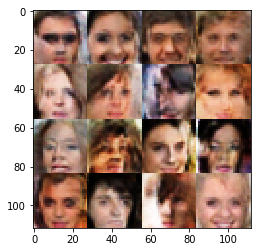

Epoch 1/1... Generator Loss: 0.4000 Discriminator Loss: 1.6800...
Epoch 1/1... Generator Loss: 0.7082 Discriminator Loss: 1.1378...
Epoch 1/1... Generator Loss: 3.0641 Discriminator Loss: 0.5392...
Epoch 1/1... Generator Loss: 0.6060 Discriminator Loss: 1.2845...
Epoch 1/1... Generator Loss: 0.5416 Discriminator Loss: 1.4710...
Epoch 1/1... Generator Loss: 1.4229 Discriminator Loss: 0.7014...
Epoch 1/1... Generator Loss: 0.6681 Discriminator Loss: 1.2682...
Epoch 1/1... Generator Loss: 1.3857 Discriminator Loss: 0.9244...
Epoch 1/1... Generator Loss: 0.9119 Discriminator Loss: 0.9998...
Epoch 1/1... Generator Loss: 0.5326 Discriminator Loss: 1.3009...


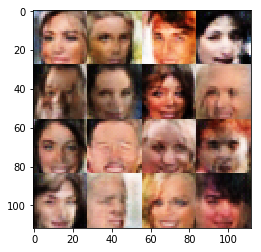

Epoch 1/1... Generator Loss: 1.7371 Discriminator Loss: 0.8504...
Epoch 1/1... Generator Loss: 1.2494 Discriminator Loss: 0.7876...
Epoch 1/1... Generator Loss: 1.5794 Discriminator Loss: 0.6717...
Epoch 1/1... Generator Loss: 1.4564 Discriminator Loss: 0.9265...
Epoch 1/1... Generator Loss: 1.3739 Discriminator Loss: 0.7944...
Epoch 1/1... Generator Loss: 0.6946 Discriminator Loss: 1.4415...
Epoch 1/1... Generator Loss: 0.6526 Discriminator Loss: 1.1798...
Epoch 1/1... Generator Loss: 1.9102 Discriminator Loss: 0.8463...
Epoch 1/1... Generator Loss: 1.0011 Discriminator Loss: 1.0015...
Epoch 1/1... Generator Loss: 0.8804 Discriminator Loss: 1.0757...


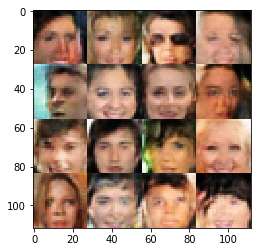

Epoch 1/1... Generator Loss: 0.9050 Discriminator Loss: 1.0151...
Epoch 1/1... Generator Loss: 1.6555 Discriminator Loss: 0.7305...
Epoch 1/1... Generator Loss: 1.2567 Discriminator Loss: 0.7773...
Epoch 1/1... Generator Loss: 0.6370 Discriminator Loss: 1.3807...
Epoch 1/1... Generator Loss: 0.5988 Discriminator Loss: 1.3985...
Epoch 1/1... Generator Loss: 0.9146 Discriminator Loss: 1.4648...
Epoch 1/1... Generator Loss: 0.9774 Discriminator Loss: 0.9793...
Epoch 1/1... Generator Loss: 1.7355 Discriminator Loss: 0.7170...
Epoch 1/1... Generator Loss: 1.3946 Discriminator Loss: 0.7725...
Epoch 1/1... Generator Loss: 0.7817 Discriminator Loss: 1.4940...


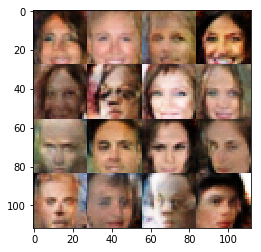

Epoch 1/1... Generator Loss: 1.6226 Discriminator Loss: 0.7723...
Epoch 1/1... Generator Loss: 1.6222 Discriminator Loss: 0.9559...
Epoch 1/1... Generator Loss: 0.7276 Discriminator Loss: 1.1476...
Epoch 1/1... Generator Loss: 0.9298 Discriminator Loss: 0.9553...
Epoch 1/1... Generator Loss: 1.2903 Discriminator Loss: 0.8891...
Epoch 1/1... Generator Loss: 1.3604 Discriminator Loss: 0.8078...
Epoch 1/1... Generator Loss: 1.6554 Discriminator Loss: 1.0694...
Epoch 1/1... Generator Loss: 0.6483 Discriminator Loss: 1.2958...
Epoch 1/1... Generator Loss: 1.1838 Discriminator Loss: 1.0129...
Epoch 1/1... Generator Loss: 1.0921 Discriminator Loss: 1.0277...


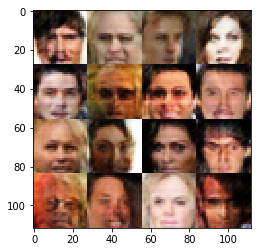

Epoch 1/1... Generator Loss: 1.8048 Discriminator Loss: 0.7554...
Epoch 1/1... Generator Loss: 1.3965 Discriminator Loss: 0.7350...
Epoch 1/1... Generator Loss: 0.9579 Discriminator Loss: 0.9721...
Epoch 1/1... Generator Loss: 1.7043 Discriminator Loss: 0.6632...
Epoch 1/1... Generator Loss: 0.8055 Discriminator Loss: 1.0694...
Epoch 1/1... Generator Loss: 0.5671 Discriminator Loss: 1.3184...
Epoch 1/1... Generator Loss: 2.2716 Discriminator Loss: 0.8985...
Epoch 1/1... Generator Loss: 3.0090 Discriminator Loss: 0.4828...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.1846...
Epoch 1/1... Generator Loss: 2.0371 Discriminator Loss: 0.5910...


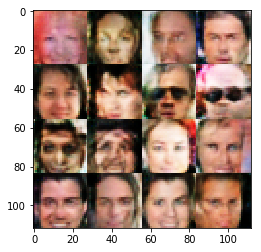

Epoch 1/1... Generator Loss: 0.8563 Discriminator Loss: 0.9773...
Epoch 1/1... Generator Loss: 0.9910 Discriminator Loss: 0.9734...
Epoch 1/1... Generator Loss: 3.5208 Discriminator Loss: 0.8358...
Epoch 1/1... Generator Loss: 0.7719 Discriminator Loss: 1.3321...
Epoch 1/1... Generator Loss: 1.5966 Discriminator Loss: 0.7105...
Epoch 1/1... Generator Loss: 0.6140 Discriminator Loss: 1.2702...
Epoch 1/1... Generator Loss: 1.7509 Discriminator Loss: 0.9594...
Epoch 1/1... Generator Loss: 1.4317 Discriminator Loss: 0.7501...
Epoch 1/1... Generator Loss: 0.9663 Discriminator Loss: 1.2813...
Epoch 1/1... Generator Loss: 0.8229 Discriminator Loss: 1.2652...


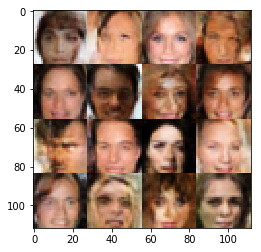

Epoch 1/1... Generator Loss: 1.0224 Discriminator Loss: 1.1980...
Epoch 1/1... Generator Loss: 0.8565 Discriminator Loss: 1.1331...
Epoch 1/1... Generator Loss: 1.8469 Discriminator Loss: 0.6862...
Epoch 1/1... Generator Loss: 1.8899 Discriminator Loss: 0.7344...
Epoch 1/1... Generator Loss: 0.7169 Discriminator Loss: 1.2112...
Epoch 1/1... Generator Loss: 0.9739 Discriminator Loss: 1.0355...
Epoch 1/1... Generator Loss: 0.6480 Discriminator Loss: 1.2118...
Epoch 1/1... Generator Loss: 1.0485 Discriminator Loss: 1.0265...
Epoch 1/1... Generator Loss: 0.8223 Discriminator Loss: 1.0843...
Epoch 1/1... Generator Loss: 0.4986 Discriminator Loss: 1.4204...


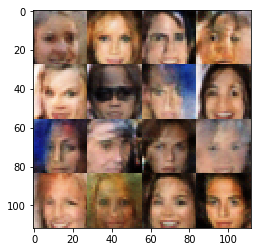

Epoch 1/1... Generator Loss: 0.8637 Discriminator Loss: 1.0161...
Epoch 1/1... Generator Loss: 0.9003 Discriminator Loss: 1.0667...
Epoch 1/1... Generator Loss: 1.1579 Discriminator Loss: 1.2587...
Epoch 1/1... Generator Loss: 0.9485 Discriminator Loss: 1.2192...
Epoch 1/1... Generator Loss: 1.0327 Discriminator Loss: 0.9324...
Epoch 1/1... Generator Loss: 1.0534 Discriminator Loss: 0.8934...
Epoch 1/1... Generator Loss: 1.0528 Discriminator Loss: 1.2689...


KeyboardInterrupt: 

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.